In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir('C:/Users/wissam_T/Desktop/5th/2nd semester/ml + dm')
from tqdm.notebook import tqdm_notebook as tqdm
import re
tqdm.pandas()
from collections import defaultdict
import seaborn as sns
import missingno as msno

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']

# Helper Functions Overview

This section defines custom helper functions to analyze and visualize the dataset, evaluate machine learning models, and preprocess data. These functions are designed to streamline exploratory data analysis (EDA) and model evaluation for the car dataset, with a focus on the target variable `price` or its log-transformed version `log_price`.

- **Functions Defined**:
  - `null_with_percentage`: Displays null value counts and percentages for each column.
  - `evaluate`: Computes regression metrics (RMSE, R², MAE, MedAE) for model evaluation.
  - `plot_results`: Visualizes model performance with plots (actual vs. predicted, residuals, feature importances).
  - `evaluate_pipeline`: Fits a pipeline, predicts on validation data, and computes metrics with cross-validation.
  - `full_eda_report`: Generates a comprehensive EDA report (shape, info, missing values, etc.).
  - `numerical_report`: Analyzes numerical columns with histograms, boxplots, and KDE plots.
  - `target_report`: Analyzes the target variable (e.g., `price`) with descriptive statistics and visualizations.
  - `categorical_report`: Analyzes categorical columns, showing unique values, null counts, and bar plots.
  - `pie_chart_categorical`: Creates pie charts for categorical columns.
  - `correlation_analysis`: Computes and visualizes correlations (Spearman or Pearson) with the target.
  - `group_by_log_boxplot`: Creates boxplots of log-transformed target values grouped by categorical features.
  - `eta_squared_dict`: Calculates eta-squared to measure categorical feature importance.
  - `masked_correlation_heatmap`: Displays a masked correlation heatmap for numerical features.
  - `numeric_numeric_analysis`: Creates pairplots for numerical features and the target.
  - `scatter_colored`: Generates scatter plots colored by a categorical feature.
  - `detect_outliers_iqr`: Identifies outliers in numerical columns using the IQR method.

**Purpose**: These functions facilitate thorough EDA, model evaluation, and feature analysis, tailored for a regression task predicting car prices.

In [21]:
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error

# Function for checking null values, their percentages and the dtypes
def null_with_percentage(dataframe):
    null_counts = dataframe.isnull().sum()
    null_percentages = (dataframe.isnull().sum() / len(dataframe)) * 100
    null_analysis = pd.DataFrame({
        'Null Count': null_counts,
        'Null Percentage': null_percentages
    }).sort_values(by='Null Percentage', ascending=False)

    print("Null Value Counts and Percentages per Column:")
    print(null_analysis)
    print("\n" + "="*70 + "\n")

def evaluate(y_true, y_pred):
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R²': r2_score(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MedAE': median_absolute_error(y_true, y_pred)
    }
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    return metrics

from sklearn.metrics import (
    mean_absolute_error,
    median_absolute_error
)

def plot_results(model_pipeline, X_val, y_val, y_pred_log, top_n_features=15):
    """
    Evaluate predictions and visualize performance and feature importances.
    Assumes y_pred_log is log1p of predicted values.
    """
    # === Convert predictions back to original scale
    y_pred = np.expm1(y_pred_log)


    # === Residuals
    residuals = y_val - y_pred

    # === Plot 1: Actual vs Predicted
    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=y_val, y=y_pred, alpha=0.3)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title("Actual vs Predicted Prices")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Plot 2: Residuals distribution
    plt.figure(figsize=(6, 5))
    sns.histplot(residuals, bins=50, kde=True)
    plt.title("Distribution of Residuals (Actual - Predicted)")
    plt.xlabel("Residual")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Plot 3: Residuals vs Actual
    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=y_val, y=residuals, alpha=0.3)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Actual Price")
    plt.ylabel("Residual")
    plt.title("Residuals vs Actual Price")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Plot 4: Feature importances (if available)
    try:
        regressor = model_pipeline.named_steps['regressor']
        if hasattr(regressor, 'feature_importances_'):
            # Get feature names from the preprocessor
            preprocessor = model_pipeline.named_steps['preprocessor']
            ohe_features = preprocessor.named_transformers_['low_cat']['onehot'].get_feature_names_out()
            num_features = numerical_cols
            high_card_features = high_cardinality_cats  # already target-encoded
            passthrough_features = binary_cols  # remainder='passthrough'

            all_features = np.concatenate([
                num_features,
                ohe_features,
                high_card_features,
                passthrough_features
            ])

            importances = regressor.feature_importances_
            sorted_idx = np.argsort(importances)[::-1][:top_n_features]

            plt.figure(figsize=(7, 6))
            sns.barplot(x=importances[sorted_idx], y=all_features[sorted_idx])
            plt.title("Top Feature Importances")
            plt.xlabel("Importance")
            plt.ylabel("Feature")
            plt.grid(True)
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print("⚠️ Could not plot feature importances:", e)

    
# Function to evaluate the pipeline
def evaluate_pipeline(pipeline, X_train, y_train, X_val, y_val):
    # Fit the pipeline on training data
    pipeline.fit(X_train, y_train)

    # Predict on validation set
    y_pred = pipeline.predict(X_val)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)

    # Perform cross-validation on training data
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')

    print(f"Validation RMSE: {rmse:.2f}")
    print(f"Validation R²: {r2:.2f}")
    print(f"Cross-validation R² scores: {cv_scores}")
    print(f"Mean CV R²: {cv_scores.mean():.2f} (±{cv_scores.std():.2f})")

    return pipeline


def full_eda_report(df, target=None, plot=True):
    print("\n📦 Dataset Overview:")
    print("Shape:", df.shape)

    print("\nInfo:")
    print(df.info())

    print("\nDescribe:")
    print(df.describe(include='all'))

    print("\nColumns:", df.columns.tolist())

    print("\nUnique values per column:\n", df.nunique())
    print("\n data types :\n",df.dtypes)

    print("\nFirst 5 rows:\n", df.head())
    print("\nLast 5 rows:\n", df.tail())

    print("\nDuplicated rows:", df.duplicated().sum())

    print("\n🧼 Missing Values Analysis:")
    missing_count = df.isnull().sum()
    missing_percent = df.isnull().mean() * 100


    print("\nMissing Values Count:\n", missing_count[missing_count > 0])
    print("\nMissing Values Percentage:\n", missing_percent[missing_percent > 0])
    print("\nMissing Values sorted:\n", df.isnull().sum().sort_values(ascending=False))


    if missing_count.sum() > 0 and plot:
        print("\n📊 Missing Value Visualization:")
        plt.figure(figsize=(10, 6))
        sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
        plt.title("Missing Value Heatmap")
        plt.show()

        msno.matrix(df)
        msno.heatmap(df)
        
        
def numerical_report(df, cols, plot=True):

  for col in cols:

    print(f"\n🧮 {col}:")
    print("Skewness:", skew(df[col].dropna()))
    print("Kurtosis:", kurtosis(df[col].dropna()))
    plt.figure(figsize=(15, 5))


    if plot:

      plt.subplot(1, 3, 1)

      plt.title(f"Histogram of {col}")
      sns.histplot(df[col], kde=True,  )

      plt.xlabel(col)
      plt.ylabel("Frequency")

      plt.subplot(1, 3, 2)

      sns.boxplot(x=df[col] )

      plt.title(f"Boxplot of {col}")

      plt.subplot(1, 3, 3)

      if df[col].nunique() > 1:
        sns.kdeplot(df[col].dropna(), fill=True)
        plt.title(f"KDE of {col}")

      plt.tight_layout()
      plt.show()
          
def target_report(df, target=None, plot=True, log_plot=False):
    if target is None or target not in df.columns:
        print("⚠️ Wrong target column")
        return

    print(f"\n🎯 Target column analysis: {target}")

    # Basic info
    print(f"🔸 null values count: {df[target].isna().sum()} ({df[target].isna().mean() * 100:.2f}%)")
    print(f"🔹 unique values count: {df[target].nunique()}")

    if df[target].dtype == 'object':
        print("\n📊 Distribution of categories:\n", df[target].value_counts(normalize=True))

        if plot:
            plt.figure(figsize=(8, 4))
            sns.countplot(y=target, data=df, order=df[target].value_counts().index, palette="Set2")
            plt.title(f"🔸 Distribution of categories - {target}")
            plt.tight_layout()
            plt.show()

    else:
        data = df[target].dropna()
        print("\n📈 Descriptive analysis:")
        print(data.describe())
        print(data.value_counts())

        # 🔍 skewness analysis
        skewness = skew(data)
        kurt = kurtosis(data)
        print(f"\n📉 Skewness : {skewness:.2f}")
        print(f"📈 Kurtosis : {kurt:.2f}")

        # 🔍 analysing rare values using IQR
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        outlier_min = Q1 - 1.5 * IQR
        outlier_max = Q3 + 1.5 * IQR
        outliers = data[(data < outlier_min) | (data > outlier_max)]
        print(f"\n🚨 num of rare values (using IQR): {len(outliers)} ({len(outliers)/len(data)*100:.2f}%)")

        # plots
        if plot:
            plt.figure(figsize=(10, 5))
            sns.histplot(data, bins=60, kde=True, color='#00bfff')
            plt.axvline(data.mean(), color='red', linestyle='--', label=f"mean: {data.mean():,.0f}")
            plt.title(f"🔹 Distribution {target}")
            plt.xlabel(target)
            plt.ylabel("num of values")
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.5)
            plt.tight_layout()
            plt.show()

            plt.figure(figsize=(10, 2.5))
            sns.boxplot(x=data, color='#ff9933')
            plt.title(f"🔸 Boxplot لـ {target}")
            plt.xlabel(target)
            plt.grid(True, axis='x', linestyle='--', alpha=0.5)
            plt.tight_layout()
            plt.show()

        if log_plot:
            log_data = np.log1p(data[data > 0])
            plt.figure(figsize=(10, 5))
            sns.histplot(log_data, bins=60, kde=True, color='purple')
            plt.axvline(log_data.mean(), color='red', linestyle='--', label=f"logarithmic mean: {log_data.mean():.2f}")
            plt.title(f"🔹 logarithmic mean for {target} (log1p)")
            plt.xlabel(f"log({target} + 1)")
            plt.ylabel("num of values")
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.5)
            plt.tight_layout()
            plt.show()

def categorical_report(df,cat_cols,  plot=True, top_n=20):

  for col in cat_cols:
    print("\n🔣 Categorical col's analysis:")
    print("=" * 60)

    print(f"\n📊 Column: {col}")

    print(f"🔹 num of unique values: {df[col].nunique()}")
    missing = df[col].isna().sum()
    missing_pct = missing / len(df) * 100
    print(f"🔸 num of null values: {missing} ({missing_pct:.2f}%)")

    print(f"\n🔹 most common values:\n{df[col].value_counts().head(10)}")

    if plot:
        vc = df[col].value_counts().head(top_n)
        plt.figure(figsize=(8, 4))
        sns.barplot(x=vc.values, y=vc.index, palette="viridis", hue=vc.index, legend=False)
        plt.title(f"common distribution - {col}")
        plt.xlabel("num of repetitions")
        plt.ylabel("values")
        plt.tight_layout()
        plt.show()
          
def pie_chart_categorical(df, column, top_n=5):

    counts = df[column].value_counts(normalize=True).head(top_n) * 100
    plt.figure(figsize=(6, 6))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Percentages of top {top_n} values in the column {column}')
    plt.axis('equal')
    plt.show()
    
def correlation_analysis(df, target=None, method='spearman', figsize=(12, 10), show_target_only=True):

    num_df = df.select_dtypes(include=['number'])
    corr = num_df.corr(method=method)

    if target and target in corr.columns and show_target_only:
        print(f"🔗 Correlation between data and target value: {target} ({method})")
        target_corr = corr[[target]].drop(target).sort_values(by=target, ascending=False)
        print(target_corr)

        plt.figure(figsize=(6, len(target_corr)*0.4))
        sns.heatmap(target_corr, annot=True, cmap='coolwarm', center=0)
        plt.title(f"Correlation with {target} ({method})")
        plt.tight_layout()
        plt.show()

    else:
        print(f"🔗 entire Correlation matrix ({method})")
        plt.figure(figsize=figsize)
        sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
        plt.tight_layout()
        plt.show()

def group_by_log_boxplot(df, column, target='log_price'):
    for col in column:
        if df[col].nunique() <= 20:
            plt.figure(figsize=(10, 5))
            sns.boxplot(data=df, x=col, y=np.log1p(df[target]))
            plt.xticks(rotation=45)
            plt.title(f"log1p({target}) based on {col}")
            plt.tight_layout()
            plt.show()
            
def eta_squared_dict(df, target, columns):
    eta_dict = {}
    for col in columns:
        grand_mean = df[target].mean()
        groups = df.groupby(col)
        ss_between = sum([len(g[target]) * (g[target].mean() - grand_mean) ** 2 for _, g in groups])
        ss_total = sum((df[target] - grand_mean) ** 2)
        eta_sq = ss_between / ss_total
        eta_dict[col] = eta_sq
        print(f"η² ({col} → {target}) = {eta_sq:.4f}")
    return eta_dict

def masked_correlation_heatmap(df, method='pearson'):

    corr = df.select_dtypes(include='number').corr(method=method)
    mask = np.triu(np.ones_like(corr, dtype=bool))

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=True, center=0)
    plt.title(f'{method.capitalize()} Correlation Heatmap (Masked)')
    plt.show()
    
def numeric_numeric_analysis(df, sample_size=1000):
    df_sample = df[num_cols + [target]].dropna().sample(n=sample_size, random_state=42)
    sns.pairplot(df_sample, corner=True)
    plt.show()
    
def scatter_colored(df, x='odometer', y='log_price', hue='fuel', sample_size=5000):
    df_sample = df.sample(n=sample_size, random_state=42) if len(df) > sample_size else df
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_sample, x=x, y=y, hue=hue, alpha=0.5)
    plt.title(f"colored {hue} in comparision with {x} based on {y}")
    plt.show()
    
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_mask = (data[column] < lower_bound) | (data[column] > upper_bound)
    return outlier_mask

# To prevent any data leakage we will split our data to test and train then split train to val and train

# Loading the Dataset

In [11]:
og_vehicles_df = pd.read_csv("data/vehicles.csv") 

In [12]:
from sklearn.model_selection import train_test_split

# Test being the final testing data
train_val, test = train_test_split(og_vehicles_df, test_size=0.2, random_state=42)

In [13]:
#train is the data we will work on
#val is the data we will validate on before testing
train, val = train_test_split(train_val, test_size=0.2, random_state=42)

# Exploratory Data Analysis (EDA) Report

## Dataset Overview
First, let's understand what each column represents:

| Column           | Description |
|------------------|-------------|
| `id`             | Unique identifier for each listing |
| `url`            | Link to the car listing |
| `region`         | Geographic region where the car is listed |
| `region_url`     | URL of the region page |
| `price`          | Selling price (target variable) |
| `year`           | Year the car was manufactured |
| `manufacturer`   | Brand of the car (e.g., Toyota, Ford) |
| `model`          | Specific model of the vehicle |
| `condition`      | Reported condition (e.g., good, like new) |
| `cylinders`      | Engine cylinder count |
| `fuel`           | Fuel type (e.g., gas, diesel, hybrid) |
| `odometer`       | Mileage of the car |
| `title_status`   | Title/legal status of the car |
| `transmission`   | Gear type (e.g., manual, automatic) |
| `VIN`            | Vehicle Identification Number |
| `drive`          | Drive type (e.g., 4WD, FWD, RWD) |
| `size`           | Size class (e.g., compact, full-size) |
| `type`           | Body type (e.g., SUV, sedan) |
| `paint_color`    | Exterior color |
| `image_url`      | Link to the car image |
| `description`    | Seller-provided description |
| `county`         | County name (often missing) |
| `state`          | U.S. state abbreviation |
| `lat`, `long`    | Geographic coordinates |
| `posting_date`   | Date the listing was posted |

---

## Numerical Analysis
Key numerical columns: `year`, `odometer`, `lat`, `long`, `log_price`

### Findings:
1. **Year**: Will be left as-is (other features will supplement it)
2. **Odometer**: 
   - Will flag outliers 
   - Using log transformation for standardization
3. **Lat/Long**: 
   - Expected skewness is normal
   - Will be replaced with engineered geo-features

### Target Variable (`price`):
- Created log-transformed version: `log_price = log1p(price)`
- IQR Analysis:


📦 Dataset Overview:
Shape: (273203, 26)

Info:
<class 'pandas.core.frame.DataFrame'>
Index: 273203 entries, 298217 to 314411
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            273203 non-null  int64  
 1   url           273203 non-null  object 
 2   region        273203 non-null  object 
 3   region_url    273203 non-null  object 
 4   price         273203 non-null  int64  
 5   year          272419 non-null  float64
 6   manufacturer  261936 non-null  object 
 7   model         269840 non-null  object 
 8   condition     161707 non-null  object 
 9   cylinders     159448 non-null  object 
 10  fuel          271308 non-null  object 
 11  odometer      270351 non-null  float64
 12  title_status  267941 non-null  object 
 13  transmission  271590 non-null  object 
 14  VIN           170036 non-null  object 
 15  drive         189613 non-null  object 
 16  size          77191 non-null   object 
 17  

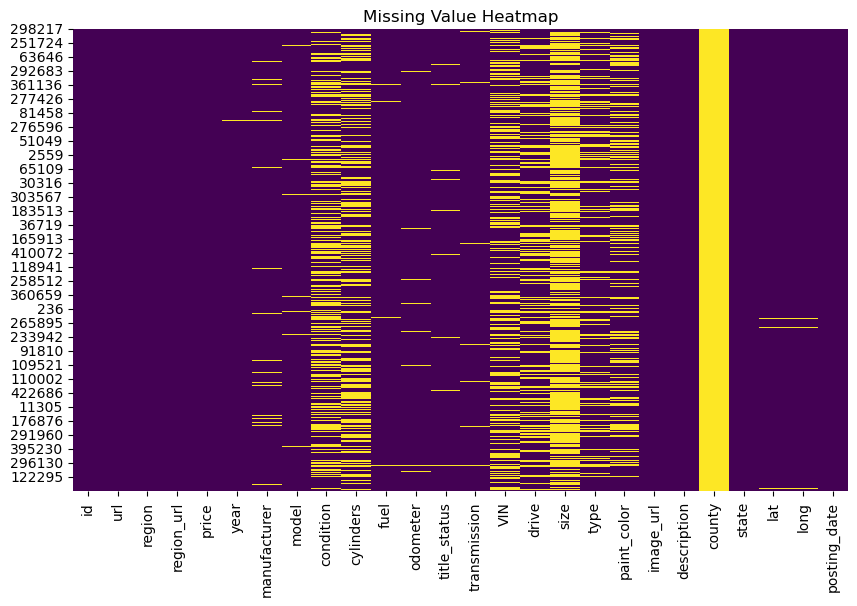

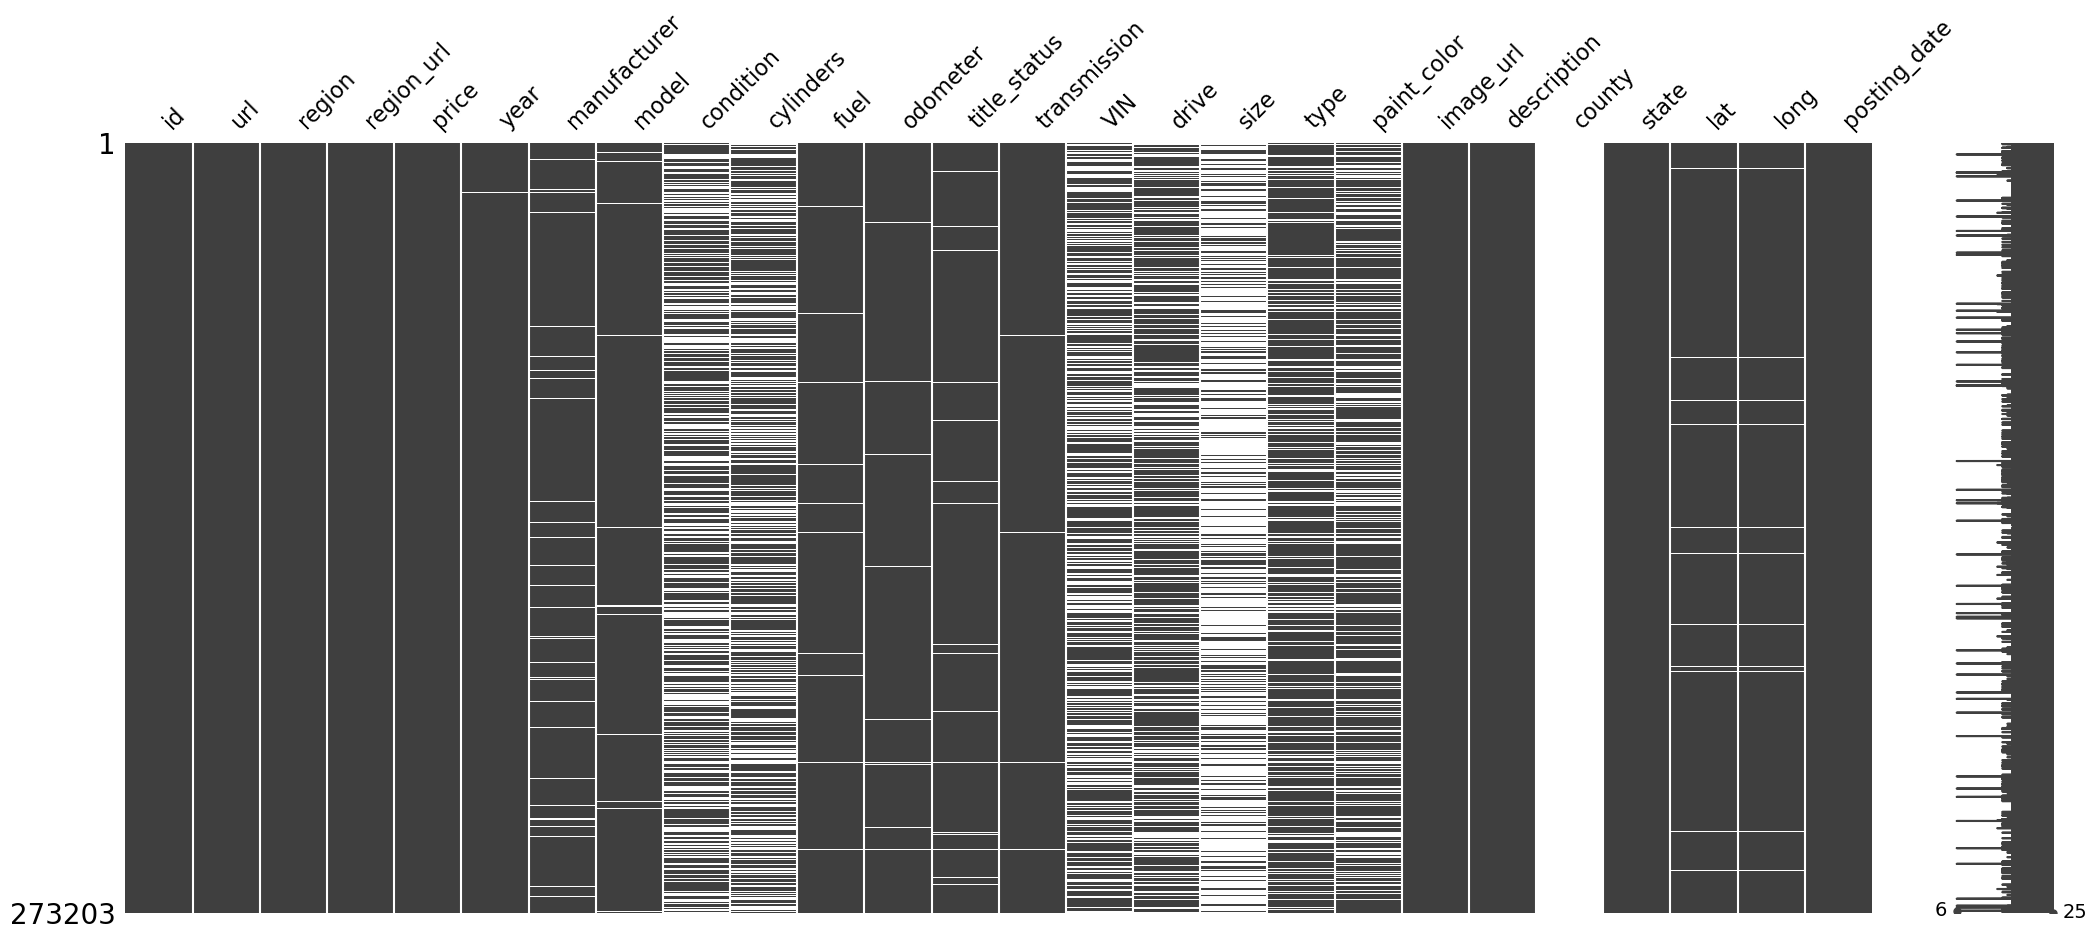

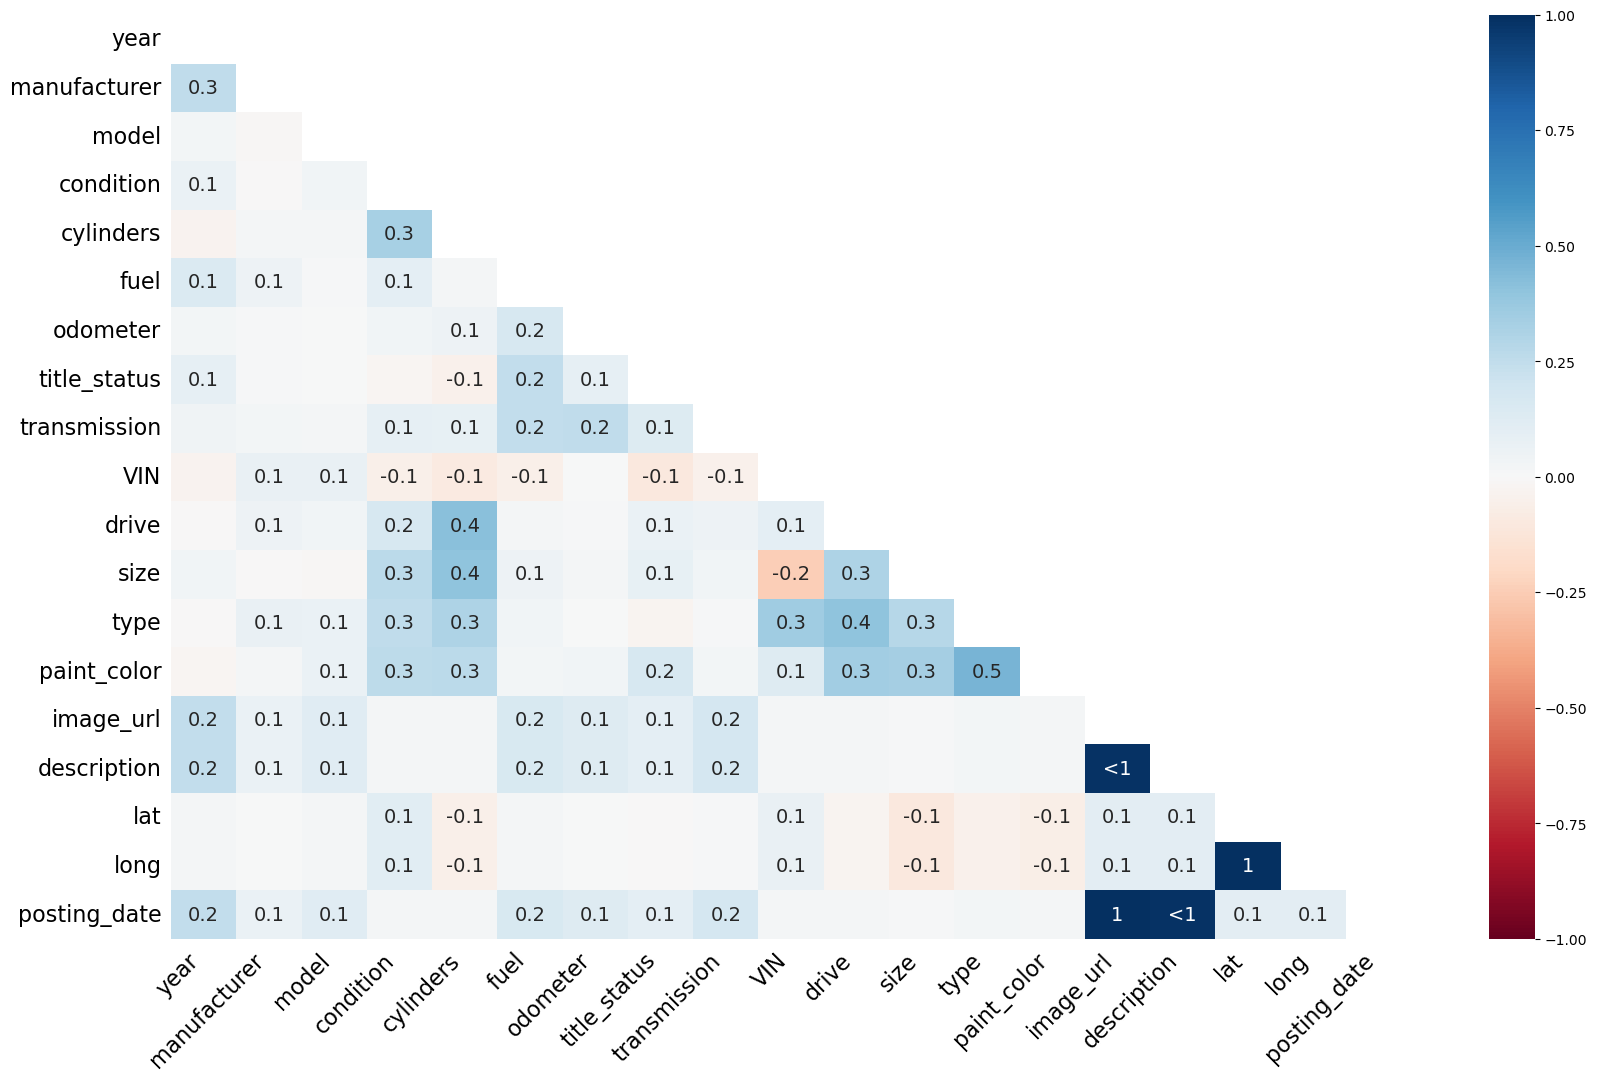

In [14]:
full_eda_report(train,target='price')

In [15]:
train.duplicated(subset=['year', 'manufacturer', 'model', 'odometer', 'price']).value_counts()

False    172640
True     100563
Name: count, dtype: int64

## lets analyze our num cols


In [23]:
target = 'price'
cat_cols = ['region', 'manufacturer', 'model', 'condition', 'cylinders',
            'fuel', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state']
num_cols = ['year', 'odometer', 'lat', 'long', 'log_price', ]

train['log_price'] = np.log1p(train['price'])

C:\Users\wissam_T\AppData\Local\Temp\ipykernel_17500\2813045234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['log_price'] = np.log1p(train['price'])



🔢 Numerical Feature  {col} Analysis:

🧮 year:
Skewness: -3.443013558445989
Kurtosis: 17.90690331314351


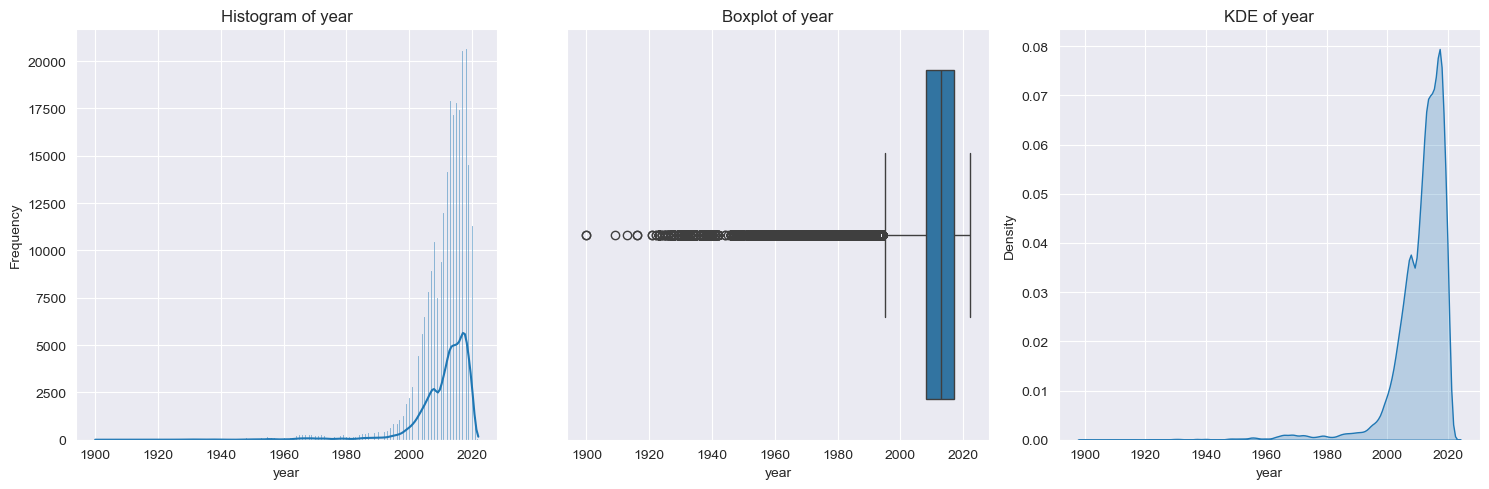


🔢 Numerical Feature  {col} Analysis:

🧮 odometer:
Skewness: 40.5564941652446
Kurtosis: 1969.811299494907


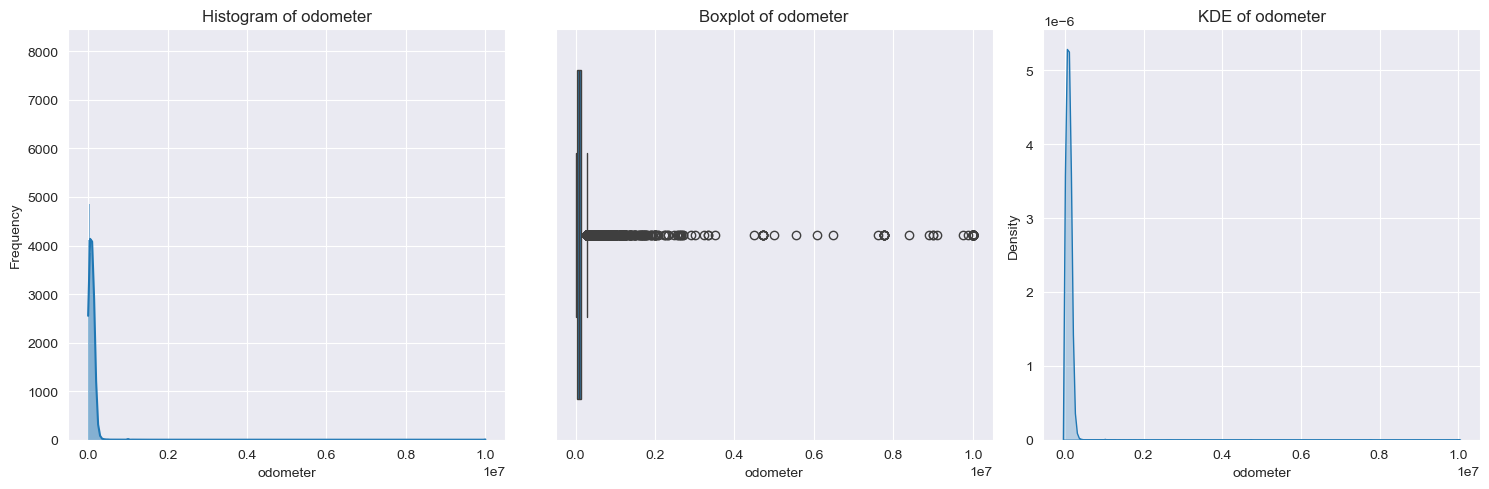


🔢 Numerical Feature  {col} Analysis:

🧮 lat:
Skewness: -0.16400445524591215
Kurtosis: 4.713383828098461


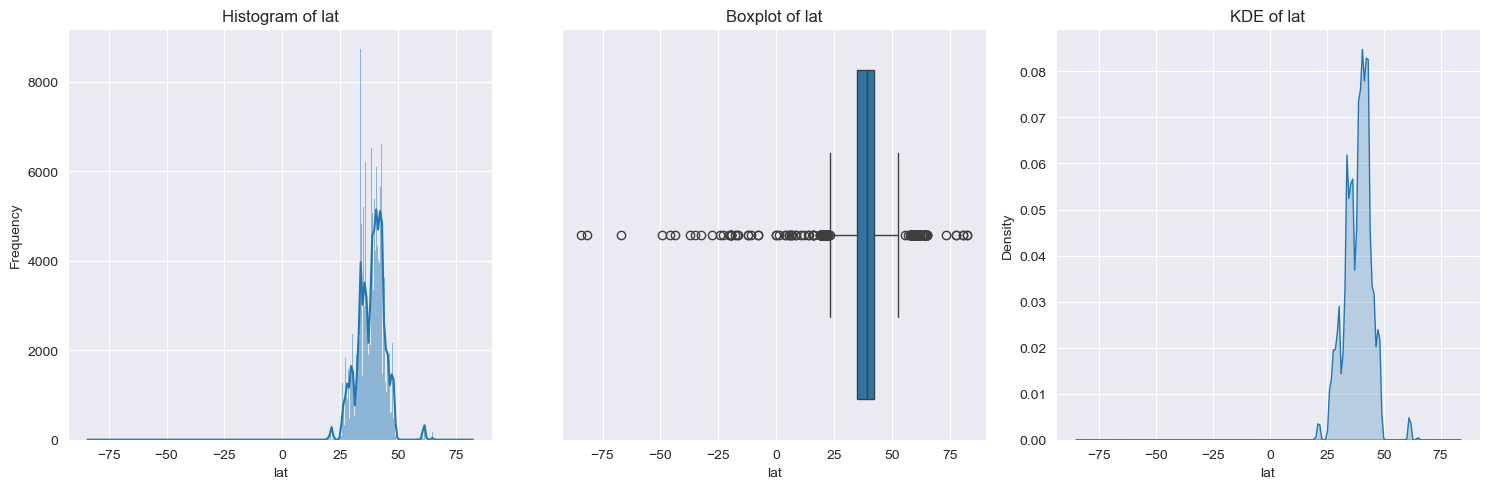


🔢 Numerical Feature  {col} Analysis:

🧮 long:
Skewness: -0.7238280782944329
Kurtosis: 1.1030731860881362


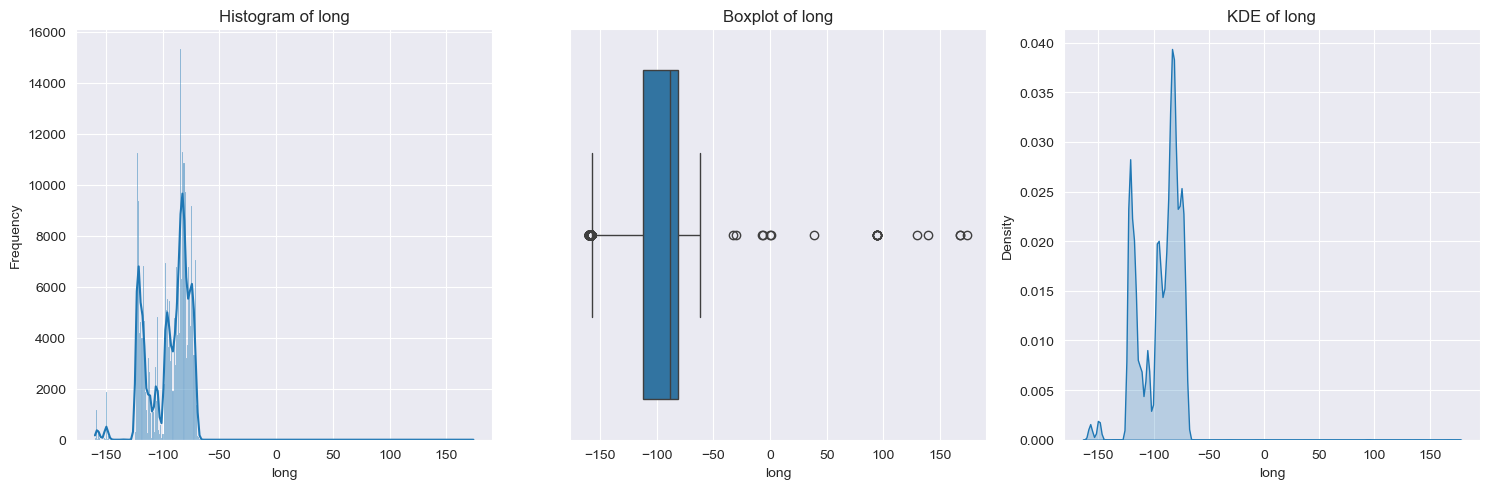


🔢 Numerical Feature  {col} Analysis:

🧮 log_price:
Skewness: -1.1351076692515756
Kurtosis: 3.007088334538029


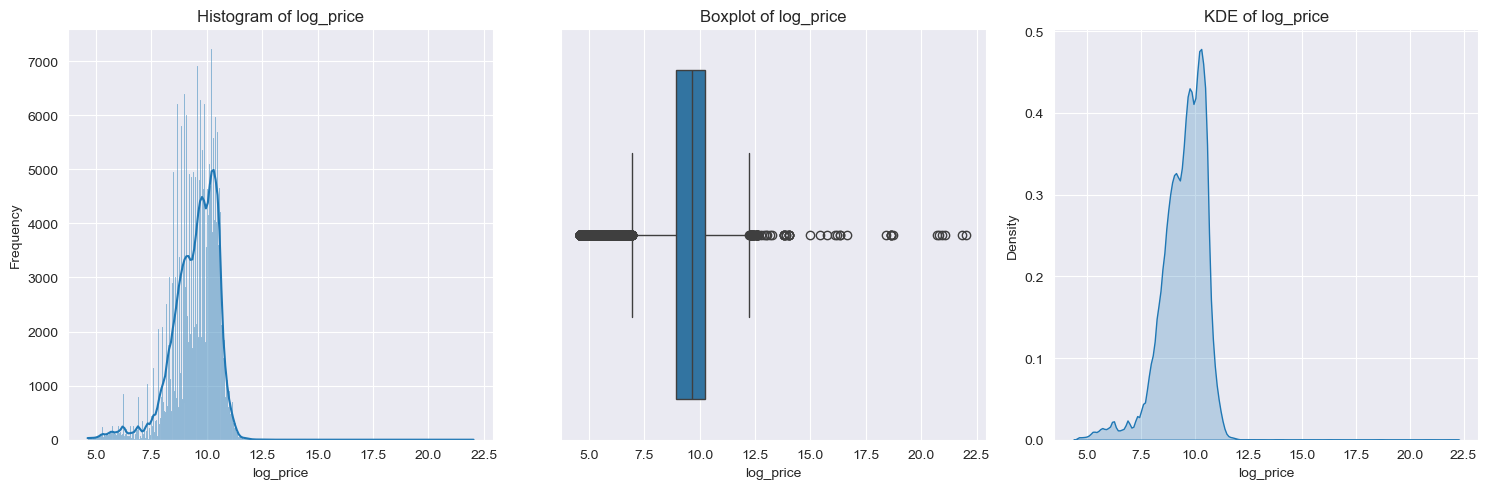

In [24]:
from scipy.stats import skew, kurtosis

numerical_report(train)


🎯 Target column analysis: price
🔸 null values count: 0 (0.00%)
🔹 unique values count: 12959

📈 Descriptive analysis:
count    2.500390e+05
mean     6.835242e+04
std      1.075585e+07
min      1.000000e+02
25%      7.495000e+03
50%      1.554400e+04
75%      2.790000e+04
max      3.736929e+09
Name: price, dtype: float64
price
7995     2002
6995     1987
9995     1849
8995     1797
4500     1771
         ... 
97998       1
39452       1
7905        1
31092       1
42445       1
Name: count, Length: 12959, dtype: int64

📉 Skewness : 279.27
📈 Kurtosis : 85899.65

🚨 num of rare values (using IQR): 4892 (1.96%)


C:\Users\wissam_T\AppData\Local\Temp\ipykernel_17500\478013255.py:169: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) Arial.
  plt.tight_layout()
A:\programs\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


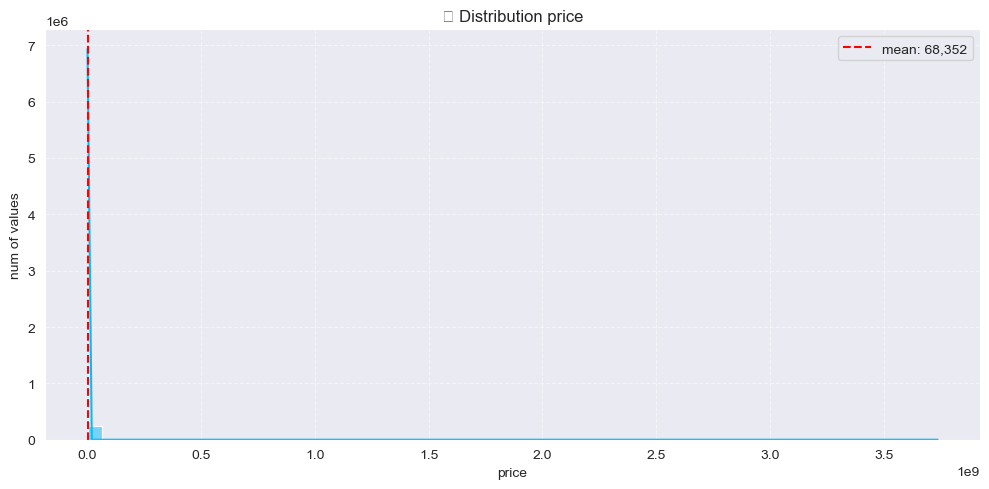

C:\Users\wissam_T\AppData\Local\Temp\ipykernel_17500\478013255.py:177: UserWarning: Glyph 128312 (\N{SMALL ORANGE DIAMOND}) missing from font(s) Arial.
  plt.tight_layout()
A:\programs\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128312 (\N{SMALL ORANGE DIAMOND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


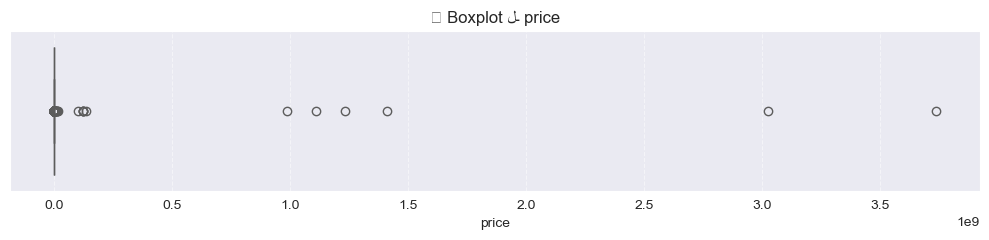

In [28]:
target_report(train,'price')

In [30]:
# calculating first and 3rd quantiles
Q1 = train['price'].quantile(0.25)
Q3 = train['price'].quantile(0.75)
IQR = Q3 - Q1

# identifying upper and lower bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("🔺 acceptable upper bounds:", upper_bound)
print("🔻 acceptable lower bounds:", lower_bound)

🔺 acceptable upper bounds: 58507.5
🔻 acceptable lower bounds: -23112.5



🔣 Categorical col's analysis:

📊 Column: region
🔹 num of unique values: 404
🔸 num of null values: 0 (0.00%)

🔹 most common values:
region
columbus                  2177
jacksonville              2010
grand rapids              1882
las vegas                 1875
milwaukee                 1867
omaha / council bluffs    1850
central NJ                1841
sarasota-bradenton        1841
north jersey              1836
tucson                    1828
Name: count, dtype: int64


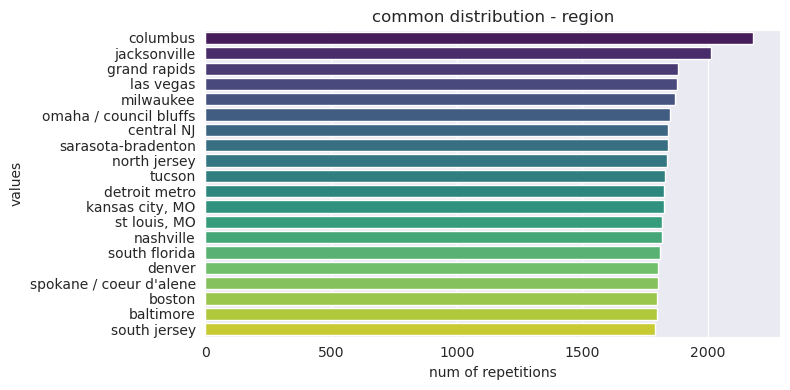


🔣 Categorical col's analysis:

📊 Column: manufacturer
🔹 num of unique values: 42
🔸 num of null values: 10120 (4.05%)

🔹 most common values:
manufacturer
ford         41159
chevrolet    32067
toyota       20029
honda        12679
jeep         11238
nissan       11030
ram          10440
gmc           9821
bmw           8733
dodge         7748
Name: count, dtype: int64


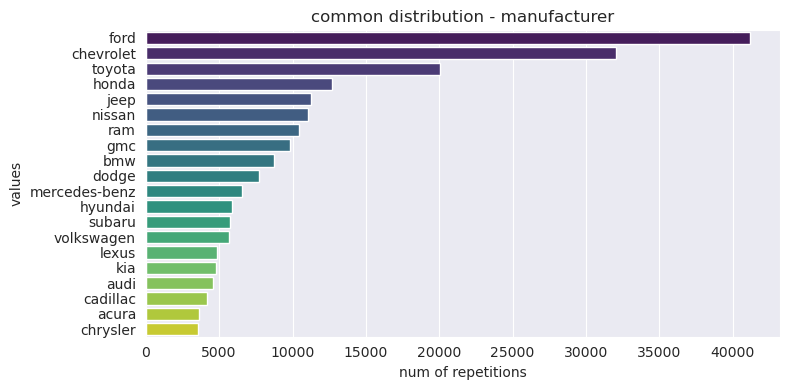


🔣 Categorical col's analysis:

📊 Column: model
🔹 num of unique values: 22203
🔸 num of null values: 2917 (1.17%)

🔹 most common values:
model
f-150             4475
silverado 1500    2922
1500              2372
silverado         1784
camry             1781
accord            1760
wrangler          1694
civic             1656
escape            1592
altima            1545
Name: count, dtype: int64


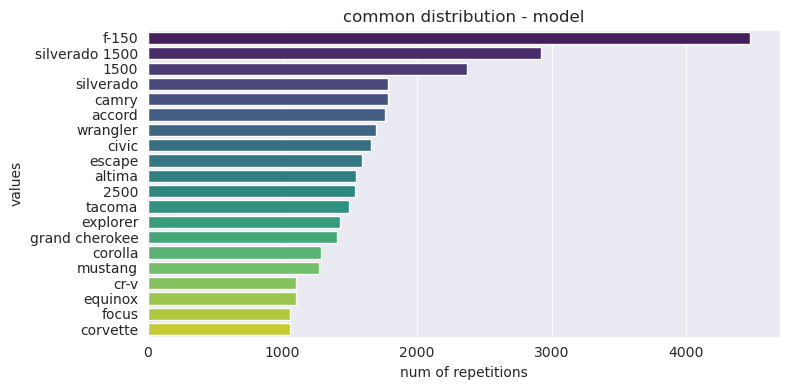


🔣 Categorical col's analysis:

📊 Column: condition
🔹 num of unique values: 6
🔸 num of null values: 95807 (38.32%)

🔹 most common values:
condition
good         76143
excellent    60025
like new     12764
fair          4260
new            674
salvage        366
Name: count, dtype: int64


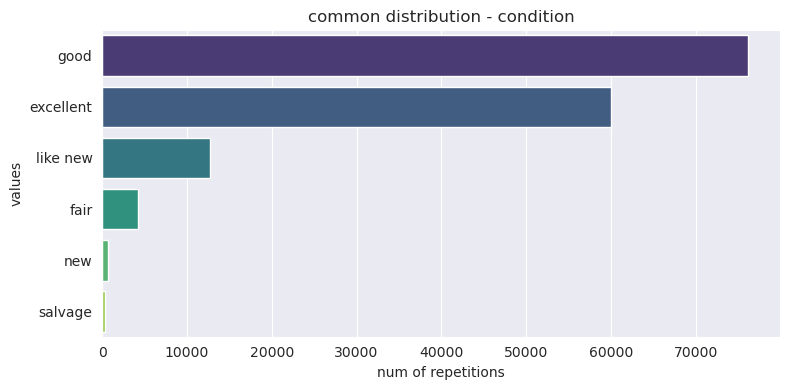


🔣 Categorical col's analysis:

📊 Column: cylinders
🔹 num of unique values: 8
🔸 num of null values: 101564 (40.62%)

🔹 most common values:
cylinders
6 cylinders     56661
4 cylinders     46436
8 cylinders     42366
5 cylinders      1080
10 cylinders      753
other             662
3 cylinders       381
12 cylinders      136
Name: count, dtype: int64


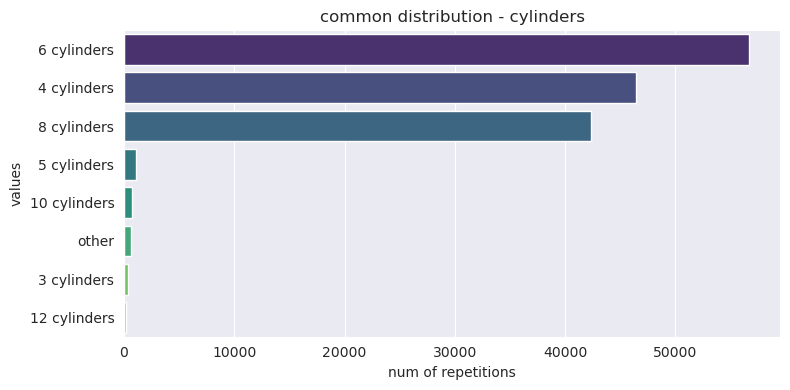


🔣 Categorical col's analysis:

📊 Column: fuel
🔹 num of unique values: 5
🔸 num of null values: 1635 (0.65%)

🔹 most common values:
fuel
gas         209861
other        17758
diesel       16627
hybrid        3082
electric      1076
Name: count, dtype: int64


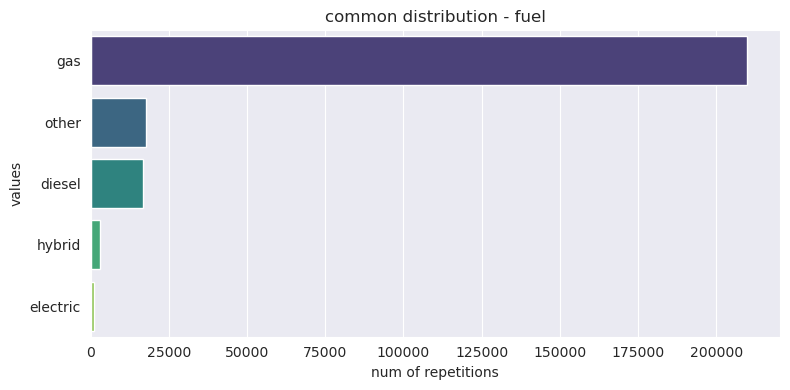


🔣 Categorical col's analysis:

📊 Column: transmission
🔹 num of unique values: 3
🔸 num of null values: 1141 (0.46%)

🔹 most common values:
transmission
automatic    194811
other         38926
manual        15161
Name: count, dtype: int64


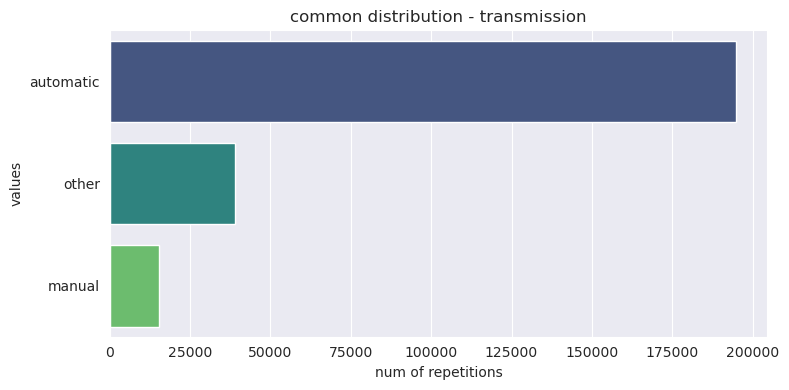


🔣 Categorical col's analysis:

📊 Column: drive
🔹 num of unique values: 3
🔸 num of null values: 76282 (30.51%)

🔹 most common values:
drive
4wd    76454
fwd    62158
rwd    35145
Name: count, dtype: int64


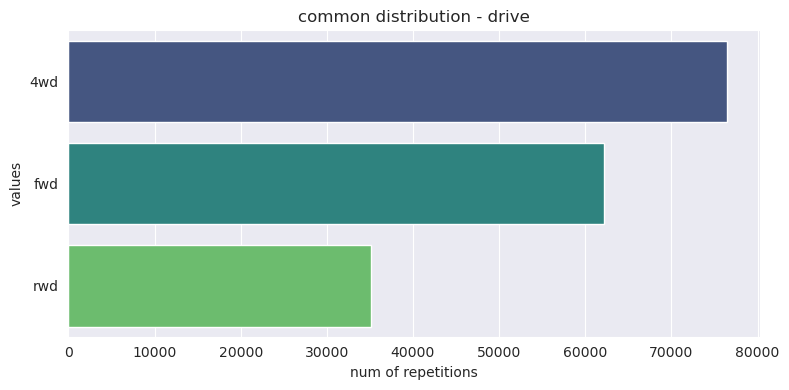


🔣 Categorical col's analysis:

📊 Column: size
🔹 num of unique values: 4
🔸 num of null values: 180128 (72.04%)

🔹 most common values:
size
full-size      36640
mid-size       20335
compact        11069
sub-compact     1867
Name: count, dtype: int64


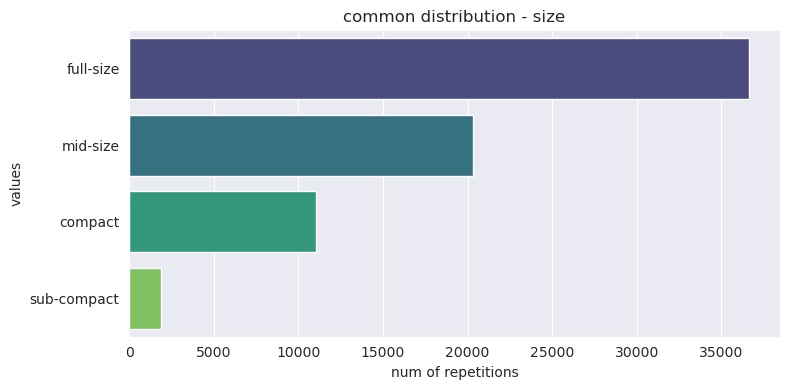


🔣 Categorical col's analysis:

📊 Column: type
🔹 num of unique values: 13
🔸 num of null values: 54231 (21.69%)

🔹 most common values:
type
sedan          50670
SUV            45167
pickup         26383
truck          19330
other          12750
coupe          11486
hatchback      10152
wagon           6343
van             5028
convertible     4846
Name: count, dtype: int64


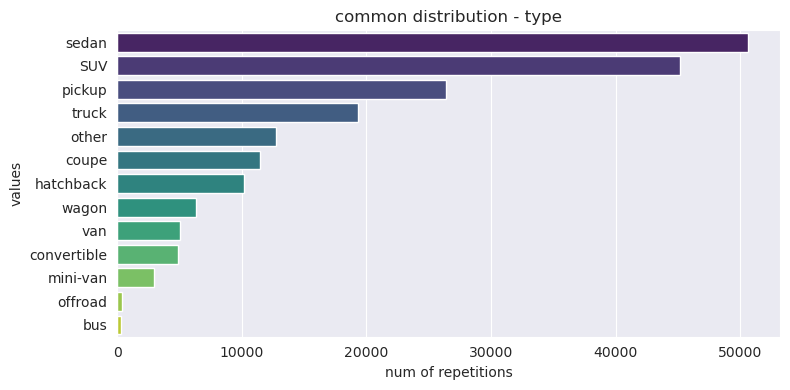


🔣 Categorical col's analysis:

📊 Column: paint_color
🔹 num of unique values: 12
🔸 num of null values: 74108 (29.64%)

🔹 most common values:
paint_color
white     46406
black     37451
silver    25455
blue      18606
red       18304
grey      14442
green      4433
custom     4006
brown      3971
yellow     1274
Name: count, dtype: int64


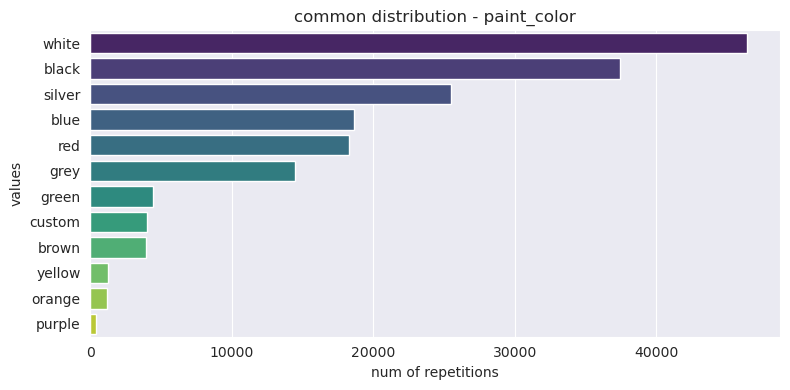


🔣 Categorical col's analysis:

📊 Column: state
🔹 num of unique values: 51
🔸 num of null values: 0 (0.00%)

🔹 most common values:
state
ca    28837
fl    16729
tx    13521
ny    11454
oh    10553
mi    10509
or     9059
pa     8247
nc     8118
wa     7927
Name: count, dtype: int64


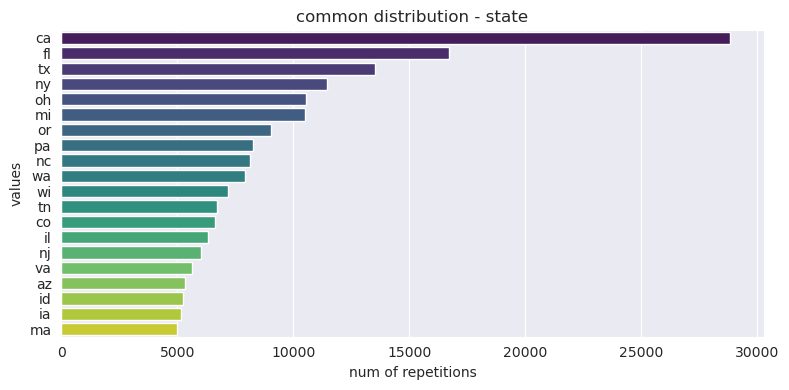

In [54]:
categorical_report(train,cat_cols)

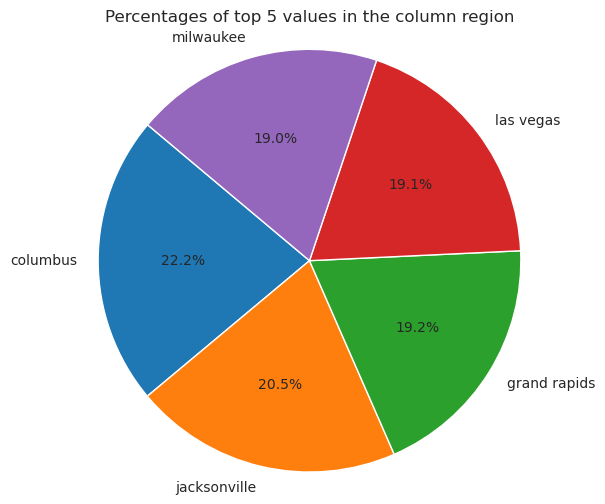

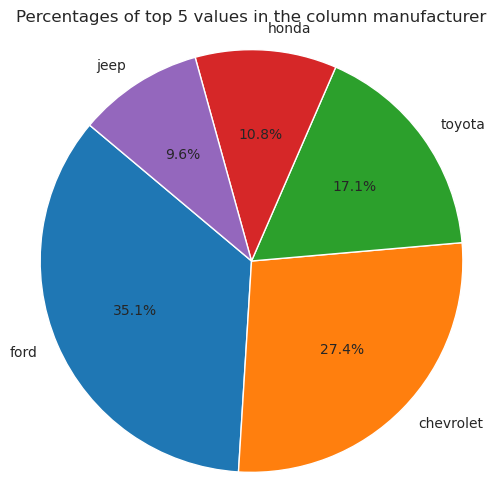

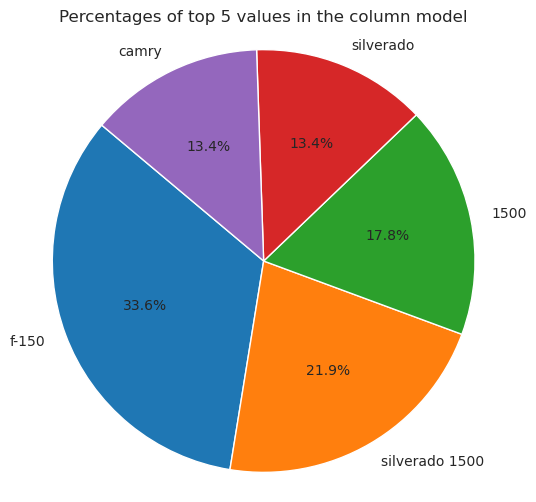

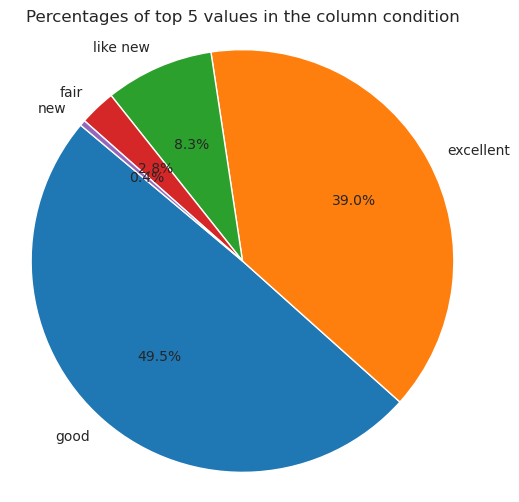

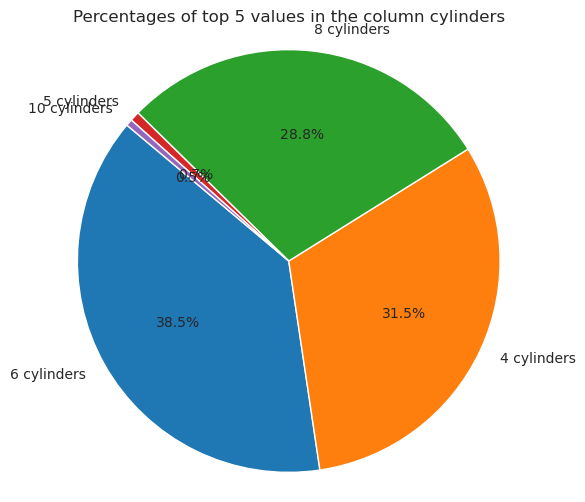

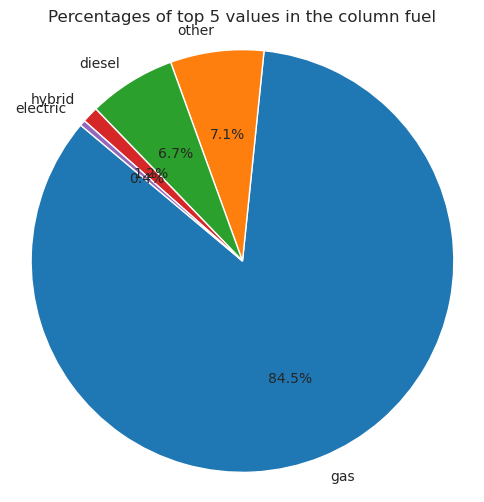

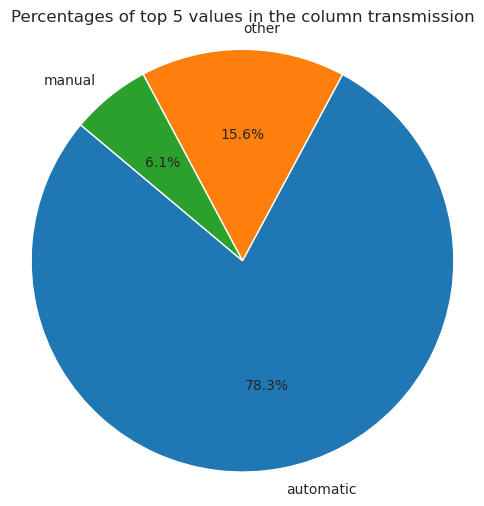

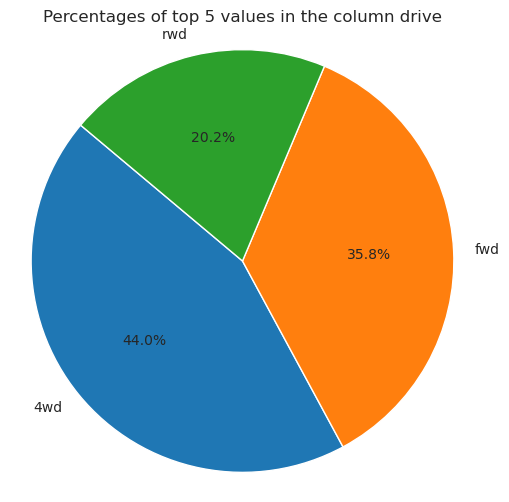

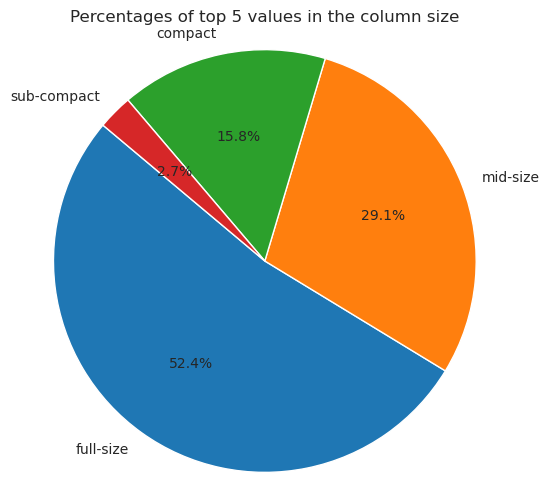

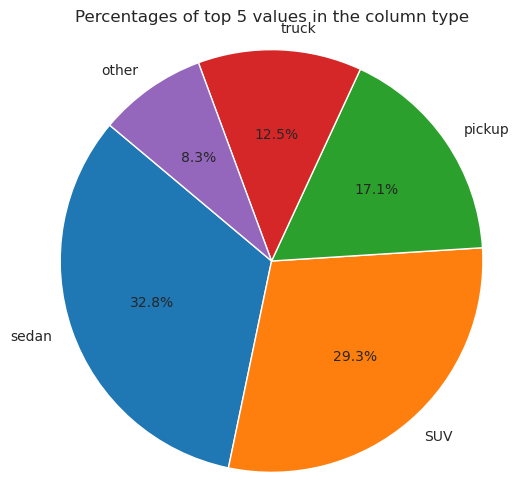

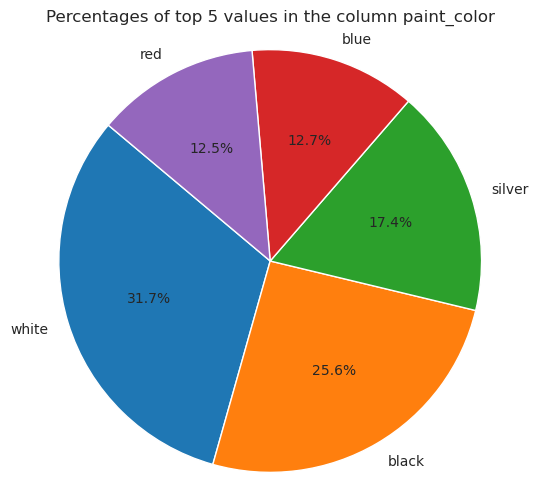

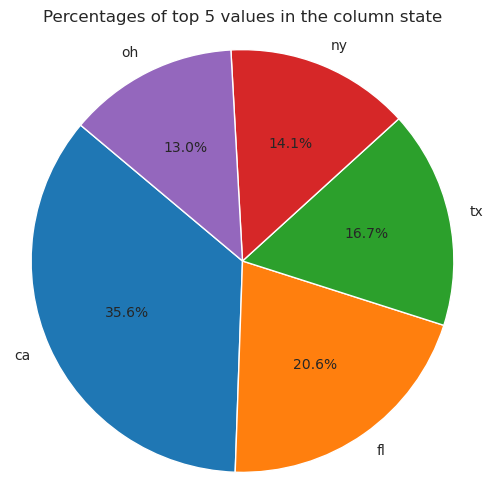

In [51]:
for col in cat_cols:
    pie_chart_categorical(train, col)

🔗 Correlation between data and target value: log_price (spearman)
          log_price
price      1.000000
year       0.639058
lat       -0.040673
long      -0.065338
id        -0.091591
odometer  -0.572990
county          NaN


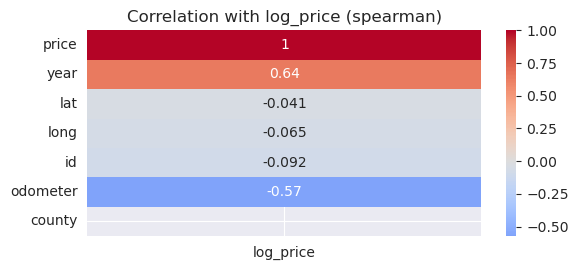

In [56]:
correlation_analysis(train,target='log_price')

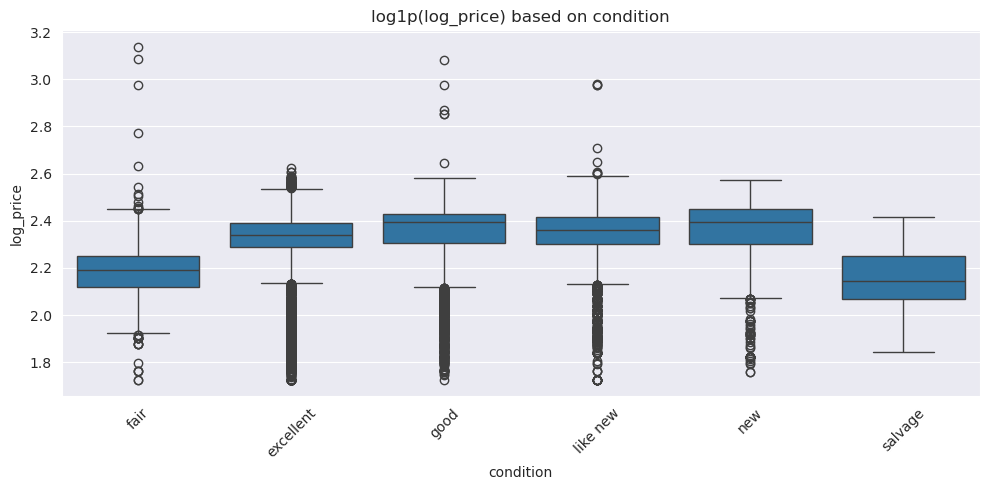

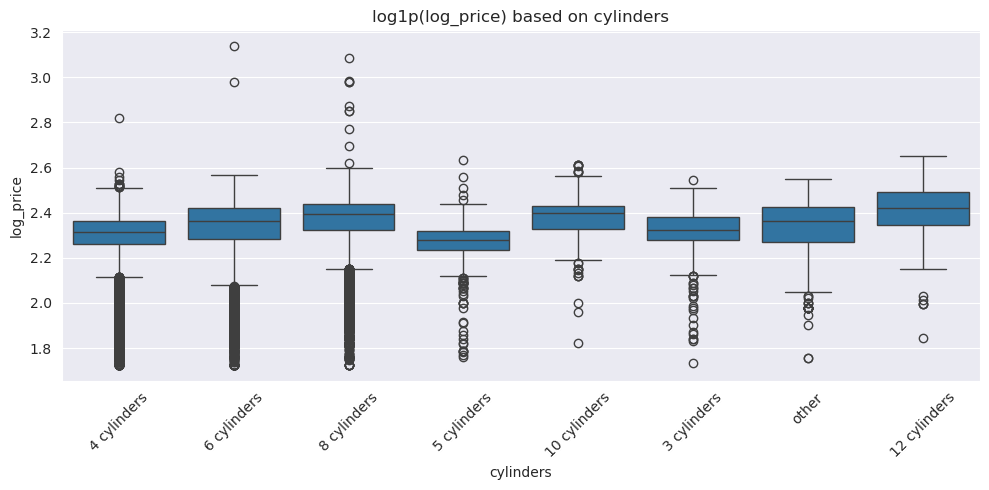

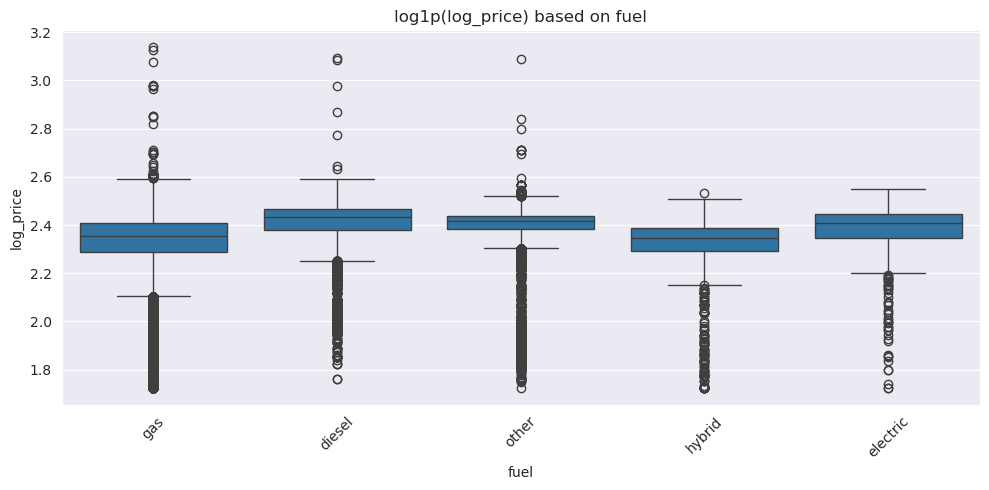

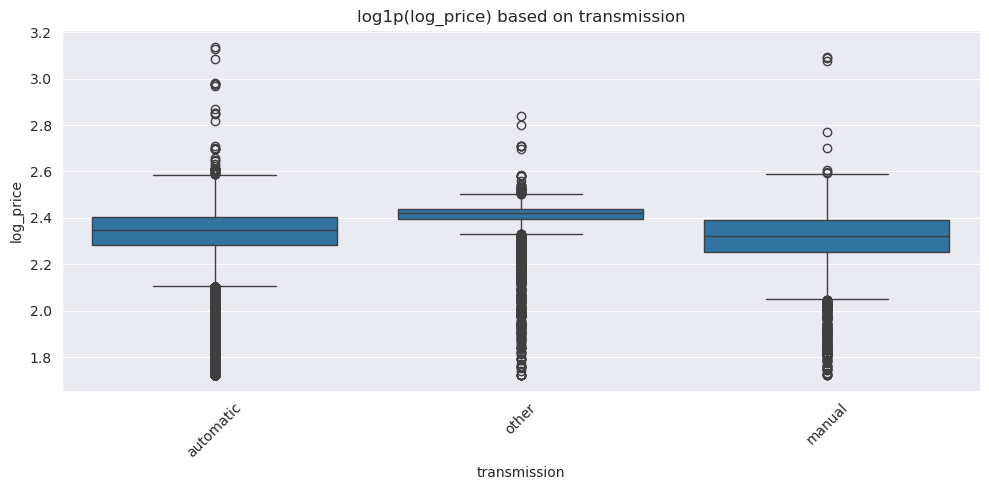

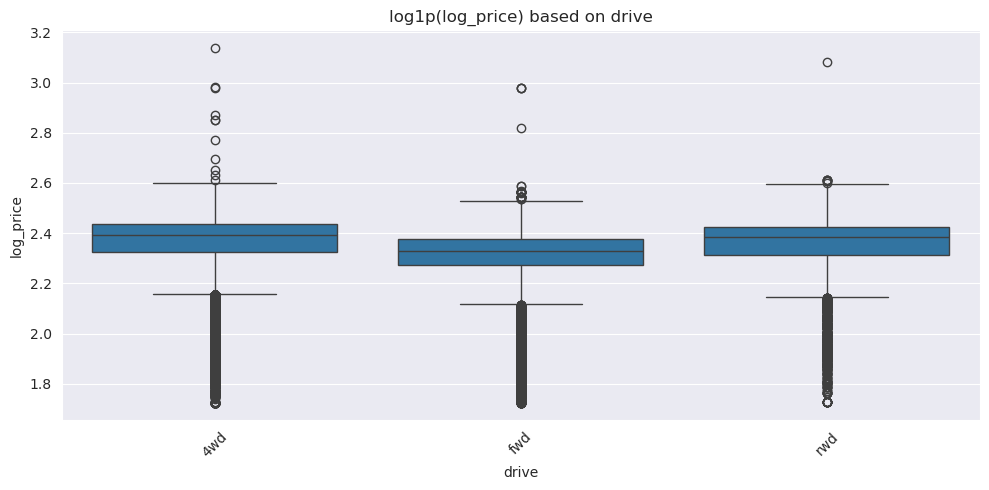

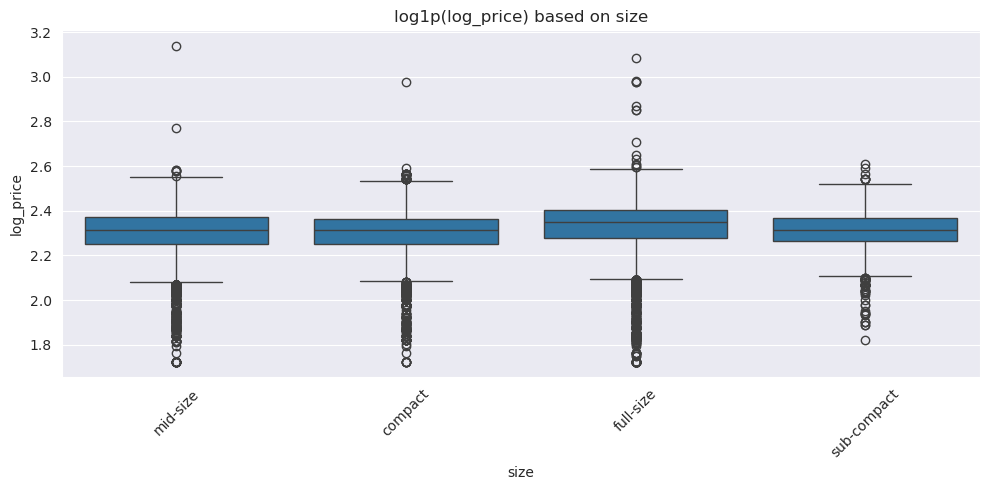

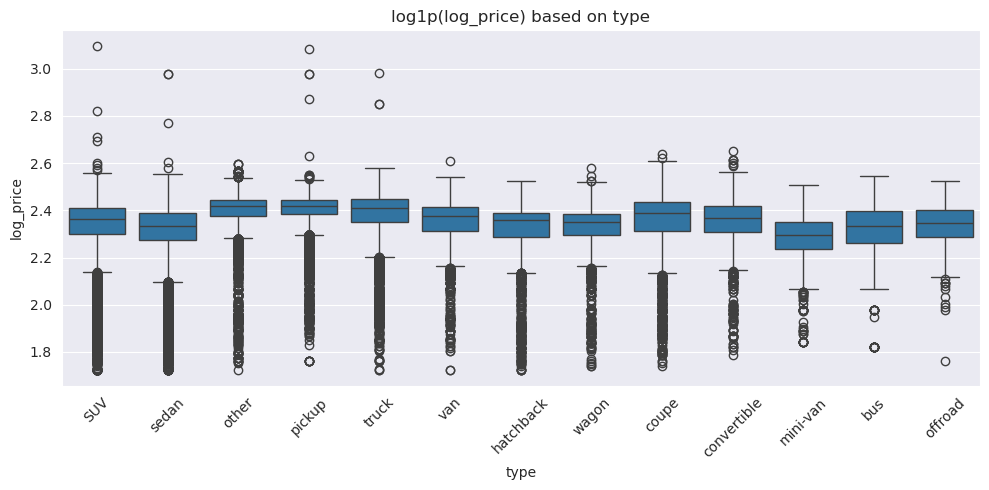

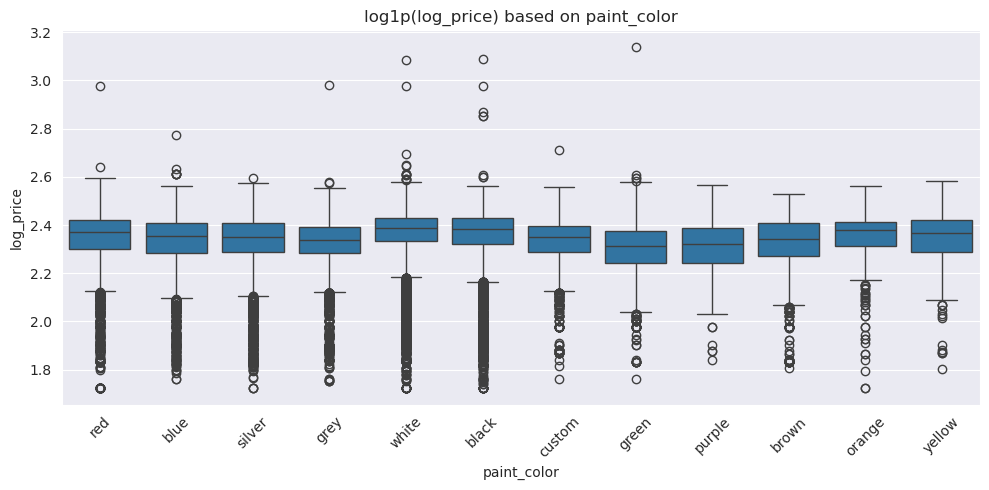

In [60]:
group_by_log_boxplot(train, cat_cols)

In [63]:
eta_results = eta_squared_dict(train, 'log_price', cat_cols)

strong_eta = {k: v for k, v in eta_results.items() if v > 0.01}
print("\n📌 columns with η² > 0.01:")
print(strong_eta)

η² (region → log_price) = 0.0610
η² (manufacturer → log_price) = 0.0762
η² (model → log_price) = 0.4954
η² (condition → log_price) = 0.0560
η² (cylinders → log_price) = 0.0578
η² (fuel → log_price) = 0.0622
η² (transmission → log_price) = 0.0855
η² (drive → log_price) = 0.0475
η² (size → log_price) = 0.0215
η² (type → log_price) = 0.0828
η² (paint_color → log_price) = 0.0269
η² (state → log_price) = 0.0210

📌 columns with η² > 0.01:
{'region': 0.06100146063999747, 'manufacturer': 0.07618056852603271, 'model': 0.49538461355179264, 'condition': 0.05600578171344804, 'cylinders': 0.05783272773844309, 'fuel': 0.062244317619606186, 'transmission': 0.0854889210435423, 'drive': 0.047500245799612824, 'size': 0.021456486063571697, 'type': 0.0828098774416491, 'paint_color': 0.026897201895233973, 'state': 0.020977521741989708}


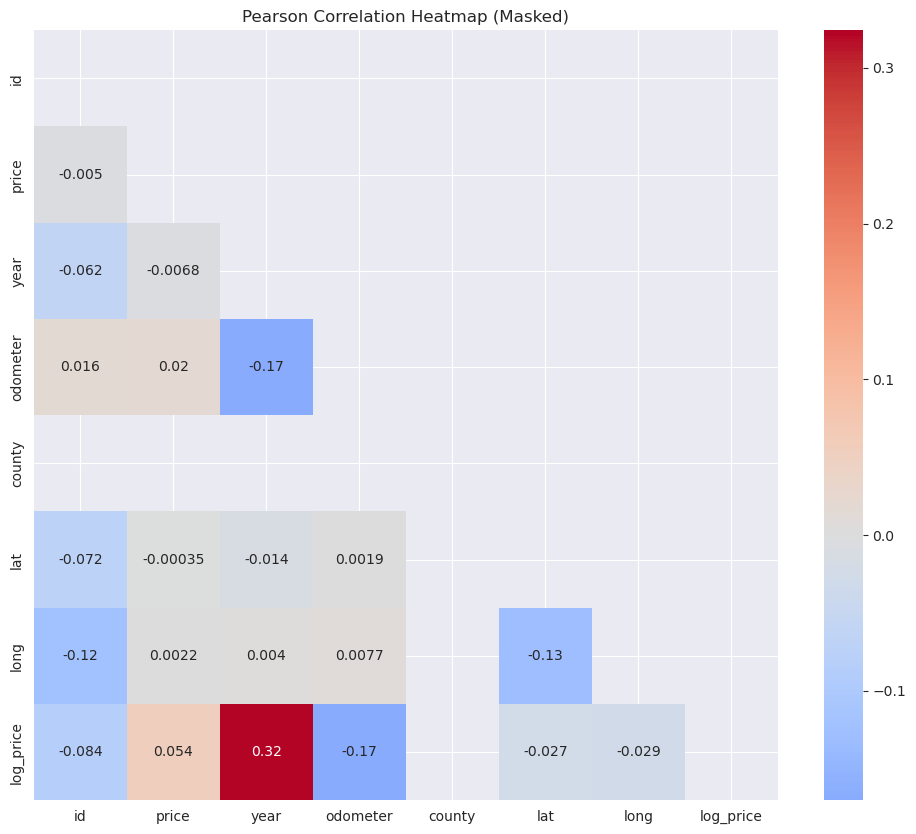

In [65]:
masked_correlation_heatmap(train, method='pearson')

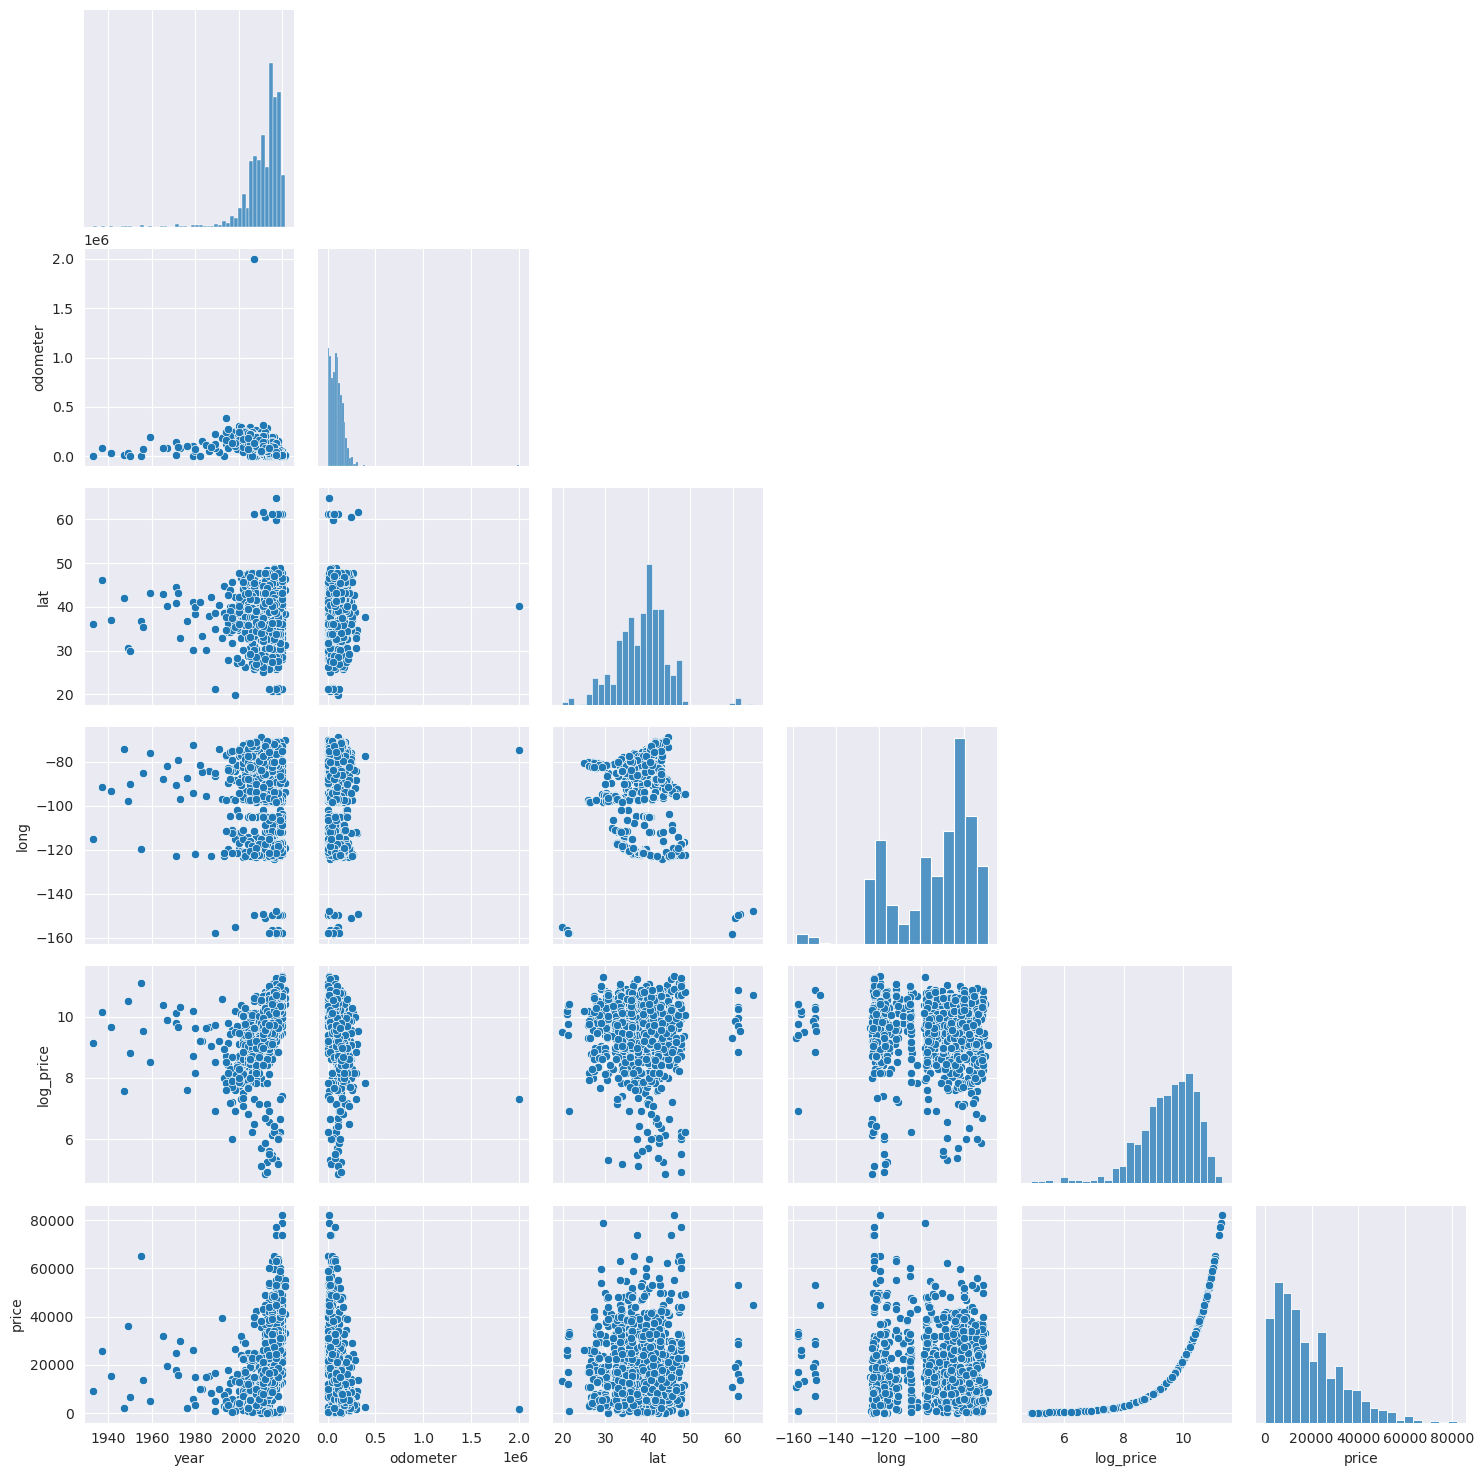

In [68]:
numeric_numeric_analysis(train)

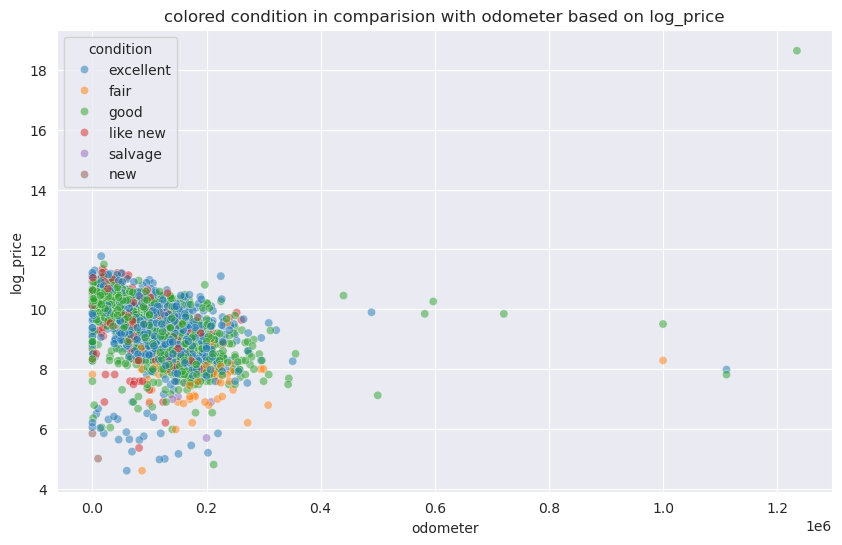

In [72]:
scatter_colored(train, x='odometer', y='log_price', hue='condition')

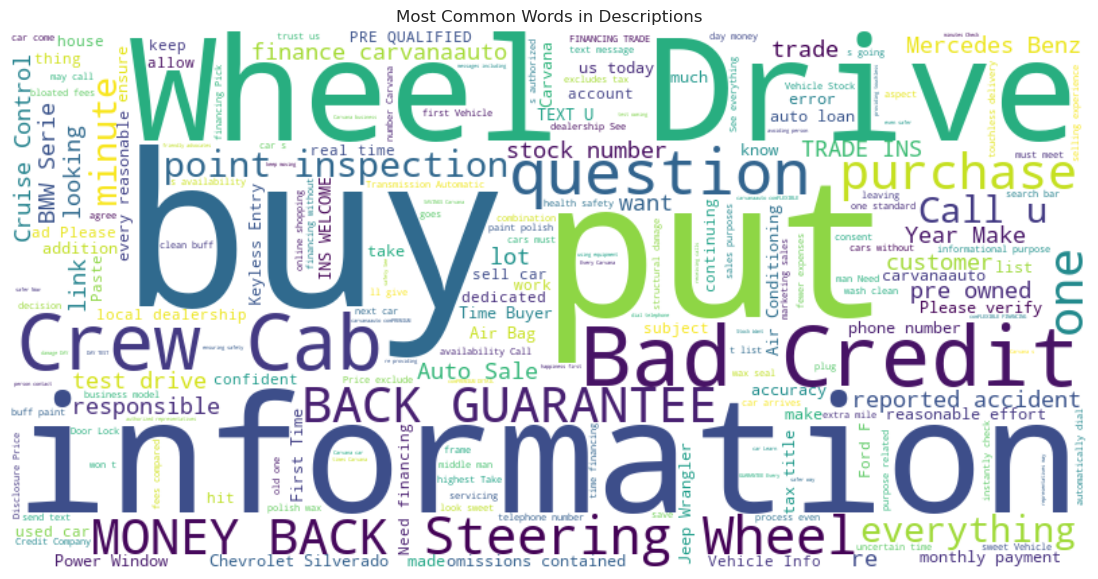

In [73]:
from wordcloud import WordCloud

text = ' '.join(train['description'].dropna().astype(str).tolist())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Descriptions")
plt.show()

# Our CarPreprocessor

## Overview
The `CarPreprocessor` class is a comprehensive data preprocessing pipeline designed to clean and transform raw car listing data into a structured format suitable for machine learning. It handles:
- Text extraction from descriptions
- Missing value imputation
- Feature engineering
- Outlier detection
- Data type standardization

## Key Features

### 1. **Pattern Matching Dictionaries**
The class contains extensive regex patterns and keyword mappings for:
- **Mileage extraction**: 15+ patterns to capture odometer readings
- **Transmission types**: 5 categories with 50+ variants
- **Drive types**: 5 categories with 40+ variants
- **Paint colors**: 12 color families with 200+ variants
- **Vehicle types**: 10 categories with 150+ variants

### 2. **Core Methods**

#### `preprocess(df)`
Main pipeline that executes all preprocessing steps in order:
1. Drops non-essential columns
2. Fills nulls using model information
3. Extracts features from descriptions
4. Performs geocoding
5. Processes special cases (EVs, cylinders, conditions)
6. Handles outliers
7. Applies smart imputation

#### `_extract_features_with_progress(df, main_progress)`
Extracts features from descriptions with nested progress bars for:
- Odometer
- Transmission
- Drive type
- Paint color
- Vehicle type
- Size
- Cylinders
- Fuel type
- Manufacturer
- Year
- Condition

#### `_smart_imputation(df)`
Intelligent null handling that:
- Drops rows missing critical fields
- Uses median odometer by make/model/year
- Imputes year with manufacturer/model median
- Fills categoricals with mode by make/model

### 3. **Specialized Processors**

#### Electric Vehicles
- Identifies EVs using manufacturer, model patterns, and description keywords
- Sets `fuel='electric'` and `cylinders='electric'` for EVs
- Handles edge cases (e.g., hybrids misclassified as EVs)

#### Cylinders Processing
- Extracts cylinder count from descriptions using 30+ patterns
- Falls back to type-based defaults (sedans→4, trucks→8)
- Creates numeric version (`cylinders_numeric`)
- Generates confidence scores for imputed values

#### Condition Estimation
- Estimates condition based on mileage bins:

In [74]:
class CarPreprocessor:
    def __init__(self):
        # Initialize any mappings or regex patterns here
        self.mileage_patterns = [
            # Standard patterns
            r'(\d{1,3}(?:,\d{3})*)\s*miles',  # 85,000 miles
            r'(\d{1,3}(?:,\d{3})*)\s*mi',     # 120,000 mi
            r'(\d+)\s*k\s*miles',              # 120k miles
            r'(\d+)\s*k\s*mi',                 # 85k mi
            r'(\d+)\s*k\b',                    # 120k
            
            # Enhanced patterns
            r'mileage:\s*(\d{1,3}(?:,\d{3})*)',
            r'odometer:\s*(\d{1,3}(?:,\d{3})*)',
            r'\b(\d{3})\s*k\b',                # 150k (3-digit)
            r'(\d+)\s*thousand\s*miles',
            r'(\d+)\s*kmiles',                 # 150kmiles
            r'(\d+)\s*,\s*(\d{3})\s*miles',    # 12,345 miles (capture both groups)
            r'approx\s*(\d+)\s*k',             # approx 120k
            r'~(\d+)\s*k',                     # ~120k
            r'around\s*(\d+)\s*k\s*miles',
            r'original\s*miles:\s*(\d+)',
            r'actual\s*miles:\s*(\d+)',
            r'\b(\d+)km?\b',                   # European style 150k
            r'(\d+)\s*[km]?\s*(?:miles|mi)',
            
            # German/European variants
            r'(\d{1,3}(?:\.\d{3})*\s*km)',    # 85.000 km
            r'(\d+)\s*tkm'                     # 150tkm (German thousands)
        ]
        self.transmission_map = {
        'automatic': [
            'auto', 'automatic', 'a/t', 'at', 'shiftless', 'self-shifting',
            'triptonic', 'steptronic', 'automanual', 'manumatic',
            'dual clutch', 'dsg', 'pdks', 's tronic', 'dct', 'speedshift',
            'powershift', 'multitronic', 'tiptronic', 'sportronic'
        ],
        'manual': [
            'manual', 'stick', 'm/t', 'mt', 'standard', '4-speed', '5-speed',
            '6-speed', 'clutch', 'h-pattern', 'floor shift', 'column shift',
            '3-pedal', 'three pedal', 'shift your own'
        ],
        'cvt': [
            'cvt', 'continuously variable', 'varitronic', 'xtronic',
            'ecvt', 'ivt', 'smartshift', 'hypertronic'
        ],
        'automated_manual': [
            'automated manual', 'amt', 'e-clutch', 'semi-auto',
            'clutchless manual', 'sequential'
        ],
        'other': [
            'direct drive', 'single speed', 'preselector', 'hydrostatic',
            'ivtm', 'torque converter'
        ]
    }
        self.drive_map = {
        'fwd': [
            'front wheel', 'fwd', 'front drive', '2wd', 'two wheel',
            'front-wheel', 'f.w.d.', 'f w d', 'forward wheel'
        ],
        'rwd': [
            'rear wheel', 'rwd', 'rear drive', '2wd', 'two wheel',
            'rear-wheel', 'r.w.d.', 'r w d', 'back wheel'
        ],
        'awd': [
            'all wheel', 'awd', '4matic', 'quattro', 'xdrive', 'sh-awd',
            '4motion', 'symmetrical awd', 'super handling awd', 's-awd',
            'torque vectoring', 'torsen', 'haldex', 'on-demand', 'full-time 4wd',
            'permanent 4wd', '4matic+', 'quattro ultra', 'dynamic torque vectoring'
        ],
        '4wd': [
            'four wheel', '4wd', '4x4', 'part-time 4wd', 'selectable 4wd',
            'shift-on-the-fly', '4 wheel drive', '4-wheel', 'four-by-four',
            '4 wd', '4 by 4', '4x4 system', '4x4 drivetrain'
        ],
        'unknown': [
            'unspecified', 'unknown', 'not specified', '?'
        ]}
        self.color_map = defaultdict(list, {
        'white': [
            'white', 'pearl', 'ivory', 'alabaster', 'chalk', 'coconut', 'diamond',
            'frost', 'glacier', 'moonstone', 'opal', 'seashell', 'snow', 'whisper',
            'cream', 'eggshell', 'vanilla', 'porcelain', 'pearl white', 'triple white'
        ],
        'black': [
            'black', 'onyx', 'ebony', 'obsidian', 'phantom', 'raven', 'sable',
            'shadow', 'vader', 'midnight', 'cosmic', 'licorice', 'piano', 'tuxedo',
            'jet', 'carbon', 'graphite', 'black sapphire', 'black noir'
        ],
        'silver': [
            'silver', 'platinum', 'metallic gray', 'brushed metal', 'steel',
            'chrome', 'argent', 'polished', 'mercury', 'moonlight silver'
        ],
        'gray': [
            'gray', 'grey', 'graphite', 'charcoal', 'ash', 'slate', 'stone',
            'cement', 'granite', 'smoke', 'pewter', 'storm', 'concrete', 'titanium'
        ],
        'red': [
            'red', 'ruby', 'burgundy', 'cherry', 'scarlet', 'maroon', 'crimson',
            'garnet', 'fire red', 'candy apple', 'vermilion', 'blood red', 'wine'
        ],
        'blue': [
            'blue', 'navy', 'sapphire', 'aqua', 'teal', 'cobalt', 'sky blue',
            'midnight blue', 'turquoise', 'steel blue', 'indigo', 'denim', 'arctic'
        ],
        'green': [
            'green', 'emerald', 'forest', 'lime', 'mint', 'olive', 'jade',
            'army green', 'seafoam', 'moss', 'avocado', 'sage', 'pine'
        ],
        'brown': [
            'brown', 'tan', 'bronze', 'copper', 'champagne', 'beige', 'mocha',
            'chocolate', 'espresso', 'cinnamon', 'pecan', 'rust', 'caramel', 'nutmeg'
        ],
        'gold': [
            'gold', 'amber', 'honey', 'topaz', 'saffron', 'sunstone', 'champagne gold'
        ],
        'yellow': [
            'yellow', 'mustard', 'lemon', 'sunflower', 'banana', 'dandelion',
            'canary', 'butter'
        ],
        'orange': [
            'orange', 'tangerine', 'coral', 'amber orange', 'burnt orange',
            'copper orange', 'pumpkin', 'sunset'
        ],
        'purple': [
            'purple', 'violet', 'plum', 'lavender', 'amethyst', 'orchid',
            'grape', 'wine purple', 'deep purple'
        ],
        'custom': [
            'matte', 'metallic', 'chrome', 'primer', 'wrapped', 'plasti-dip',
            'color changing', 'chameleon', 'two-tone', 'murdered out', 'stealth',
            'patina', 'rat rod', 'primer gray', 'custom paint', 'graphics',
            'wrap', 'fade', 'flip-flop', 'iridescent'
        ]
    })
        
        
        self.vehicle_type_map = {
        'sedan': [
            'sedan', 'saloon', '4-door', 'four door', 'notchback', 'fastback',
            'hardtop', 'post sedan', 'club sedan', 'berline', 'limousine'
        ],
        'SUV': [
            'suv', 'sport utility', 'crossover', 'jeep', 'xuv', 'sav', 'sport activity',
            'soft-roader', 'off-road', '4x4', 'high rider', 'raised', 'command driving',
            'urban cruiser'
        ],
        'truck': [
            'truck', 'pickup', 'pick-up', 'ute', 'dual cab', 'single cab', 'crew cab',
            'flatbed', 'dumper', 'box truck', 'haul truck', 'lifted truck',
            'work truck', 'chassis cab', 'trailering', 'utility truck'
        ],
        'coupe': [
            'coupe', 'coupé', '2-door', 'two door', 'sport coupe', 'notchback coupe',
            'performance coupe'
        ],
        'hatchback': [
            'hatchback', 'hatch', '3-door', '5-door', 'liftback', 'compact hatch',
            'hot hatch'
        ],
        'wagon': [
            'wagon', 'estate', 'touring', 'sport wagon', 'station wagon', 'longroof',
            'shooting brake', 'family wagon'
        ],
        'van': [
            'van', 'minivan', 'mpv', 'passenger van', 'cargo van', 'work van',
            'sprinter', 'panel van', 'shuttle van', 'family van', 'transit'
        ],
        'convertible': [
            'convertible', 'cabriolet', 'roadster', 'drop-top', 'soft top', 'ragtop',
            'open top', 'spyder', 'volante'
        ],
        'exotic': [
            'supercar', 'hypercar', 'exotic', 'gt', 'grand tourer', 'spider',
            'barchetta', 'speedster', 'targa', 'lambo', 'ferrari', 'rare import'
        ],
        'other': [
            'buggy', 'dune buggy', 'motorhome', 'rv', 'golf cart', 'side-by-side',
            'atv', 'utv', 'kart', 'classic', 'kit car'
        ]
    }
        self.size_patterns = [
        # Subcompact and Mini
        (r'\bsub[\s\-]?compact\b', 'subcompact'),
        (r'\bmini\b', 'subcompact'),
        (r'\bmicro\b', 'subcompact'),
        (r'\bkei car\b', 'subcompact'),
        (r'\bcity car\b', 'subcompact'),
        (r'\btiny\b', 'subcompact'),
        (r'\bvery small\b', 'subcompact'),
    
        # Compact
        (r'\bcompact\b', 'compact'),
        (r'\bsmall\b', 'compact'),
        (r'\b5[\s\-]?door hatch\b', 'compact'),
        (r'\bcompact suv\b', 'compact'),
        (r'\bentry level\b', 'compact'),
    
        # Mid-size
        (r'\bmid[\s\-]?size\b', 'mid-size'),
        (r'\bintermediate\b', 'mid-size'),
        (r'\bmedium\b', 'mid-size'),
        (r'\bstandard\b', 'mid-size'),
        (r'\baverage size\b', 'mid-size'),
        (r'\bmidsize suv\b', 'mid-size'),
    
        # Full-size
        (r'\bfull[\s\-]?size\b', 'full'),
        (r'\blarge\b', 'full'),
        (r'\bexecutive\b', 'full'),
        (r'\bfamily size\b', 'full'),
        (r'\bfull size truck\b', 'full'),
        (r'\boversized\b', 'full'),
    
        # Extra large / extended
        (r'\bxl\b', 'extra-large'),
        (r'\bextra[\s\-]?large\b', 'extra-large'),
        (r'\bextended\b', 'extra-large'),
        (r'\blwb\b', 'extra-large'),  # Long wheelbase
        (r'\bcrew cab\b', 'extra-large'),
        (r'\bmega cab\b', 'extra-large'),
    
        # Engine displacement (proxy for size)
        (r'\b\d\.\d\s*l\b', 'large'),
        (r'\b\d{1,2}\s*valve\b', 'large'),
        (r'\bv[\-]?\d\b', 'large'),
        (r'\b(v6|v8|v10|v12)\b', 'large'),
    
        # Marketing classes
        (r'\bfull[\s\-]?sized luxury\b', 'full'),
        (r'\bcompact crossover\b', 'compact'),
        (r'\bmini[\s\-]?suv\b', 'subcompact'),
        (r'\bmidsize crossover\b', 'mid-size'),
        (r'\bthree[-\s]?row\b', 'extra-large'),
        ]
        self.cylinder_patterns = [
        (r'\b(v\d)\b', lambda m: f"{m.group(1)[1]} cylinders"),  # V6
        (r'\b(\d)\s*(?:cyl|cylinder)s?\b', lambda m: f"{m.group(1)} cylinders"),  # 4 cyl
        (r'\b(\d)\s*[\-]?speed\b', lambda m: f"{m.group(1)} cylinders" if int(m.group(1)) in [4,6,8] else None),
        (r'\b(\d\.\d)L\b', lambda m: '6 cylinders' if float(m.group(1)) >= 3.0 else '4 cylinders'),
        (r'\b(\d)\s*[\-]pot\b', lambda m: f"{m.group(1)} cylinders"),  # 6-pot
        (r'\b(i\d)\b', lambda m: f"{m.group(1)[1]} cylinders"),  # I4
        (r'\b(rotary|wankel)\b', lambda m: 'rotary'),
        (r'\b(b\d+)\b', lambda m: f"{m.group(1)[1:]} cylinders"),  # B58 → 8
        (r'\b(n\d+)\b', lambda m: f"{m.group(1)[1:]} cylinders"),  # N55 → 6
        (r'\b(ls\d+)\b', lambda m: '8 cylinders'),  # LS engines are V8s
        (r'\b(rb\d+)\b', lambda m: '6 cylinders'),  # RB series are I6
        (r'\b(1uz|2uz|3uz)\b', lambda m: '8 cylinders'),  # Toyota UZ series
        (r'\b(k\d+[a-z]*)\b', lambda m: '4 cylinders'),  # K20, K24 are I4
        (r'\b(ej\d+)\b', lambda m: '4 cylinders'),  # Subaru EJ series
        (r'\b(sr\d+[a-z]*)\b', lambda m: '4 cylinders'),  # SR20DET etc
        (r'\b(13b|20b)\b', lambda m: 'rotary'),  # Mazda rotary
        (r'\b(v\d)\b', lambda m: f"{m.group(1)[1]} cylinders"),  # V6
        (r'\b(i\d)\b', lambda m: f"{m.group(1)[1]} cylinders"),  # I4
        (r'\b(\d)\s*cyl\b', lambda m: f"{m.group(1)} cylinders"),
        (r'\b(\d)\s*pot\b', lambda m: f"{m.group(1)} cylinders"),  # 6-pot
        (r'\b(\d)\s*spd\b', lambda m: f"{m.group(1)} cylinders" if int(m.group(1)) in [4, 6, 8] else None),
        (r'\b(b\d+)\b', lambda m: f"{m.group(1)[1:]} cylinders"),  # B58 → 8
        (r'\b(n20|n55)\b', lambda m: '4 cylinders' if m.group(1)[1:] == '20' else '6 cylinders'),
        (r'\b(ls\d)\b', lambda m: '8 cylinders'),  # LS engines
        (r'\b(2jz|7m)\b', lambda m: '6 cylinders'),  # Toyota engines
        (r'\b(rb\d+)\b', lambda m: '6 cylinders'),  # Nissan RB series
        (r'\b(13b|20b)\b', lambda m: 'rotary')  # Mazda rotary
        ]
        self.fuel_map = {
        'gas': ['gas', 'gasoline', 'petrol'],
        'diesel': ['diesel'],
        'electric': ['electric', 'ev'],
        'hybrid': ['hybrid', 'plug-in hybrid', 'phev'],
        'other': ['flex fuel', 'ethanol', 'lpg']
        }
        self.brands = ['toyota', 'honda', 'ford', 'chevrolet', 'chevy', 'nissan', 'bmw', 'mercedes', 'mazda', 'jeep',
              'subaru', 'hyundai', 'kia', 'audi', 'vw', 'volkswagen', 'dodge', 'ram', 'gmc', 'lexus', 'chrysler']
        self.condition_map = {
        # New / Like New
        'new': [
            'brand new', 'factory new', 'showroom new', 'never driven', 
            'zero miles', '0 miles', 'still in wrapper', 'with tags',
            'never titled', 'dealer fresh'
        ],
        'like new': [
            'like new', 'as new', 'near new', 'basically new', 'almost new',
            'barely used', 'gently used', 'lightly used', 'hardly used',
            'looks new', 'appears new', 'mint condition', 'pristine',
            'used but looks new', 'perfect condition'
        ],
        
        # Excellent
        'excellent': [
            'excellent', 'exceptional', 'immaculate', 'flawless', 'showroom quality',
            'well maintained', 'serviced regularly', 'garage kept', 'adult owned',
            'no issues', 'no problems', 'runs perfect', 'mechanically sound',
            'clean inside out', 'no accidents', 'no damage', 'no dents',
            'no scratches', 'no rust'
        ],
        
        # Good
        'good': [
            'good', 'good condition', 'runs good', 'runs great', 'drives well',
            'solid condition', 'minor wear', 'normal wear', 'well cared for',
            'maintained', 'some wear', 'age appropriate', 'nice condition',
            'clean title', 'no major issues', 'minor cosmetic', 'small scratches',
            'few dings'
        ],
        
        # Fair
        'fair': [
            'fair', 'fair condition', 'average condition', 'needs some work',
            'minor issues', 'cosmetic issues', 'runs but needs', 'requires tlc',
            'mechanically ok', 'body issues', 'interior wear', 'high miles',
            'mileage wear', 'old but runs', 'used daily', 'project car',
            'could use', 'peeling paint', 'faded'
        ],
        
        # Salvage / Poor
        'salvage': [
            'salvage', 'rebuilt', 'reconstructed', 'total loss', 'insurance loss',
            'flood car', 'water damage', 'hail damage', 'frame damage',
            'mechanical issues', 'engine problems', 'transmission issues',
            'doesn\'t run', 'won\'t start', 'for parts', 'parts only',
            'non-op', 'non operational', 'project only', 'needs engine',
            'needs transmission', 'needs repair', 'as is', 'junk title',
            'scrap', 'not drivable'
        ],
        
        # Special Cases
        'certified': [
            'certified', 'cpo', 'manufacturer certified', 'dealer certified',
            'warranty', 'extended warranty'
        ],
        'modified': [
            'modified', 'custom', 'upgraded', 'aftermarket', 'performance parts',
            'turbocharged', 'supercharged', 'built engine', 'stance', 'lowered',
            'lifted', 'big tires'
        ]}
        self.year_patterns = [
        # Priority patterns (most specific first)
        r'\bmy\s*(\d{4})\b',  # MY2015
        r'\bmfg\s*[:\.]?\s*(\d{4})',  # MFG:2010
        r'\bmodel\s*year\s*[:\.]?\s*(\d{4})',
        r'\bmanufactured\s*[:\.]?\s*(\d{4})',
        r'\bfirst\s*registered\s*[:\.]?\s*(\d{4})',
        r'\bproduction\s*date\s*[:\.]?\s*(\d{4})',
        r'\bbuilt\s*[:\.]?\s*(\d{4})',
        
        # General patterns
        r'\b(19[5-9]\d|20[0-3]\d|202[4-5])\b',  # Standard years
        r'\b(?:yr|year)\s*[:\.]?\s*(\d{4})',
        r'\b(?:early|late)\s*(\d{4})s?',  # early 2000s
        r'\b(\d{4})\s*model\b',
        r'\b(\d{4})\s*-\s*(\d{4})\b'  # Year ranges
        ]
        self.engine_size_map = {
        '1.0L': '3 cylinders', '1.2L': '3 cylinders',
        '1.4L': '4 cylinders', '1.5L': '4 cylinders',
        '1.6L': '4 cylinders', '1.8L': '4 cylinders',
        '2.0L': '4 cylinders', '2.4L': '4 cylinders',
        '2.5L': '4 cylinders', '3.0L': '6 cylinders',
        '3.5L': '6 cylinders', '4.0L': '8 cylinders',
        '5.0L': '8 cylinders', '6.0L': '12 cylinders'
        }
        self.type_cylinder_map = {
        'sedan': '4 cylinders',
        'compact': '4 cylinders',
        'coupe': '6 cylinders',
        'SUV': '6 cylinders',
        'truck': '8 cylinders',
        'van': '6 cylinders',
        'convertible': '6 cylinders',
        'hatchback': '4 cylinders'
        }
        self.manufacturer_defaults = {
            'toyota': '4 cylinders',
            'ford': '6 cylinders',
            'bmw': '4 cylinders',
            'chevrolet': '8 cylinders',
        }
        self.    ev_makes = {
        'tesla', 'rivian', 'lucid', 'fisker', 'polestar', 
        'nio', 'xpeng', 'li auto', 'byton', 'faraday future'
        }
        # Model patterns indicating EVs
        self.ev_model_patterns = [
        r'\be-?\d',                # e-tron, e6, e-golf
        r'\bvolt\b',               # Chevy Volt
        r'\bbolt\b',               # Chevy Bolt
        r'\bleaf\b',               # Nissan Leaf
        r'\bion(?:iq)?\b',         # Hyundai Ioniq/Ioniq5
        r'\bev\b',                 # Model EV
        r'\belectr',               # Electric, Electra
        r'\bphev\b',               # Plug-in Hybrid
        r'\bzoe\b',                # Renault Zoe
        r'\bmodel [s3xy]',         # Tesla Models
        r'\bid\b',                 # VW ID.4
        r'\b(?:\d+)i\b',           # BMW i3, i8
        r'\bmirai\b',              # Toyota Mirai
        r'\bmustang mach-e\b',     # Ford Mustang Mach-E
        ]
        # Description keywords
        self.ev_desc_keywords = [
            'electric vehicle', 'zero emission', 'battery powered',
            'ev range', 'kwh battery', 'plug in', 'charger included',
            'supercharger', 'wall connector'
        ]
        self._progress = None  # Will hold our progress bar reference
        
        
    def preprocess(self, df):
        """Main preprocessing pipeline with consistent progress bars"""
        total_steps = 7
        main_progress = tqdm(total=total_steps, 
                            desc="Overall Progress", 
                            position=0,
                            leave=True,
                            bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]',
                            ncols=100)
        
        try:
            df = df.copy()
            
            # Step 1: Column dropping
            main_progress.set_description("Dropping columns")
            cols_to_drop = ['id', 'url', 'region_url', 'county', 'image_url', 'posting_date', 'VIN', 'region']
            print("Columns before dropping:", df.columns.tolist())  # Debug
            df = df.drop(columns=cols_to_drop, errors='raise')  # Raise error if columns are missing
            print("Columns after dropping:", df.columns.tolist())  # Debug
            main_progress.update(1)
            
            # Step 2: Fill nulls
            main_progress.set_description("Filling model info")
            df = self.filling_nulls_from_other_rows_model_info(df)
            main_progress.update(1)
            
            # Step 3: Feature extraction
            main_progress.set_description("Extracting features")
            df = self._extract_features_with_progress(df, main_progress)
            
            # Step 4: Geocoding
            main_progress.set_description("Geocoding")
            df = self.fill_lat_lon_by_state(df)
            main_progress.update(1)
            
            # Remaining steps
            steps = [
                (self._process_electric_vehicles, "Processing EVs"),
                (self._process_cylinders, "Processing cylinders"),
                (self._process_conditions, "Processing conditions"),
                (self.handle_outliers, "Processing outliers"),
                (self._smart_imputation, "Applying smart imputation"),
                (self._final_cleaning, "Final cleaning")
            ]
            
            for func, desc in steps:
                main_progress.set_description(desc)
                df = func(df)
                main_progress.update(1)
            
            print("Final columns after preprocessing:", df.columns.tolist())  # Debug
            return df
        except Exception as e:
            print(f"Error in preprocess: {e}")
            raise
        finally:
            main_progress.close()
            
    def _smart_imputation(self, df):
        """
        Strategic imputation that:
        - Only drops rows where critical fields are missing
        - Uses careful odometer imputation
        """
    
        # ---- Critical columns where missing rows should be dropped ----
        critical_cols = ['title_status', 'manufacturer', 'model']
        df = df.dropna(subset=critical_cols).copy()  # Drop and re-copy to avoid warnings
    
        # ---- Odometer: Conditional Imputation ----
        if 'odometer' in df.columns and 'year' in df.columns:
            recent_mask = (df['year'] >= (pd.Timestamp.now().year - 10)) & df['odometer'].isna()
    
            grouped_median = df.groupby(['manufacturer', 'model', 'year'])['odometer'].median()
            df.loc[recent_mask, 'odometer'] = df.loc[recent_mask].apply(
                lambda row: grouped_median.get((row['manufacturer'], row['model'], row['year']), np.nan),
                axis=1
            )
    
            # Create an indicator column for whether odometer was imputed
            df.loc[:, 'odometer_imputed'] = df['odometer'].isna().astype(int)
            
        df['log_odometer'] = np.log1p(df['odometer'])

    
        # ---- Year: Bounded Imputation ----
        if 'year' in df.columns:
            mask = df['year'].isna()
            median_by_group = df.groupby(['manufacturer', 'model'])['year'].median().clip(lower=1980, upper=pd.Timestamp.now().year)
            df.loc[mask, 'year'] = df.loc[mask].apply(
                lambda row: median_by_group.get((row['manufacturer'], row['model']), np.nan),
                axis=1
            )
    
        # ---- Drop rows with remaining missing odometer or year ----
        df = df.dropna(subset=['year', 'odometer']).copy()
    
        # ---- Categorical: Manufacturer-Specific ----
        cat_cols = ['size', 'paint_color', 'drive', 'type', 'fuel', 'transmission']
        for col in cat_cols:
            if col in df.columns:
                df[col] = df.groupby(['manufacturer', 'model'])[col].transform(
                    lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x
                )
                df[col] = df[col].fillna(df[col].mode()[0])
    
        # ---- Numeric: Conditional Median ----
        num_cols = ['cylinders_numeric', 'lat', 'long']
        for col in num_cols:
            if col in df.columns:
                if col == 'cylinders_numeric':
                    df[col] = df.groupby('type')[col].transform(lambda x: x.fillna(x.median()))
                df[col] = df[col].fillna(df[col].median())
                
        df = df.dropna(subset=['cylinders_numeric']).copy()
    
        # ---- Recalculate Derived Fields ----
        if 'mileage_condition' in df.columns:
            df['mileage_condition'] = pd.cut(
                df['odometer'],
                bins=[1000, 25000, 75000, 175000, 350000, 600000, float('inf')],
                labels=['new', 'like new', 'excellent', 'good', 'fair', 'salvage'],
                right=False
            )
    
        return df

    def _extract_features_with_progress(self, df, main_progress):
        """Feature extraction with sub-progress that doesn't conflict"""
        columns_to_fill = [
            'odometer', 'transmission', 'drive', 'paint_color',
            'type', 'size', 'cylinders', 'fuel', 'manufacturer',
            'year', 'condition'
        ]
        
        with tqdm(total=len(columns_to_fill), desc="Extracting features", position=1, leave=False) as sub_progress:
            for column in columns_to_fill:
                mask = df[column].isna()
                df.loc[mask, column] = df[mask].progress_apply(
                    lambda row: self.safe_extract(row, column),
                    axis=1
                )
                sub_progress.update(1)
        
        main_progress.update(1)
        return df
    
    def filling_nulls_from_other_rows_model_info(self, df):
        
        # Step 1: Group by model and calculate mode (most common values) for categorical columns
        model_based_fill = df.groupby('model').agg({
        'manufacturer': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
        'cylinders': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
        'fuel': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
        'transmission': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
        'drive': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
        'size': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
        'type': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
        'year': lambda x: x.mode()[0] if not x.mode().empty else np.nan,    
        }).reset_index()

        # Step 2: Merge with original data to fill nulls
        for column in ['manufacturer', 'cylinders', 'fuel',
                   'transmission', 'drive', 'size', 'type', 'year']:
            df[column] = df[column].fillna(df.merge(model_based_fill, on='model', how='left')[f'{column}_y'])
        
        return df  
    
    def _process_electric_vehicles(self, df):
        """Handle electric vehicle specific processing"""
        # Ensure fuel column exists
        if 'fuel' not in df.columns:
            df['fuel'] = np.nan
            
        # Identify EVs
        ev_mask = self.identify_electric_vehicles(df)
        df.loc[ev_mask, 'fuel'] = 'electric'
        df.loc[ev_mask, 'cylinders'] = 'electric'
        return df
    
    def _process_cylinders(self, df):
        """Process cylinder information"""
        # Ensure required columns exist
        for col in ['cylinders', 'type', 'manufacturer']:
            if col not in df.columns:
                df[col] = np.nan
                
        # Fill missing cylinders
        df = self.fill_cylinders(df)
        
        # Reclassify 'other' cylinders
        mask = df['cylinders'].isin(['other', None, np.nan])
        df.loc[mask, 'cylinders'] = df.loc[mask].apply(
            self.reclassify_other_cylinders,
            axis=1
        )
        
        # Convert to numeric
        df['cylinders_numeric'] = df['cylinders'].apply(
            self.convert_cylinders_to_numeric
        )
        
        valid_cylinder_set = {3, 4, 5, 6, 8, 10, 12, 0}
        df['cylinders_numeric'] = df['cylinders_numeric'].where(
            df['cylinders_numeric'].isin(valid_cylinder_set),
            np.nan
        )
        
        return df
    
    def _process_conditions(self, df):
        """Process vehicle conditions"""
        if 'condition' not in df.columns:
            df['condition'] = np.nan
            
        df = self.estimate_condition_by_mileage(df)
        df = self.fill_condition_with_context(df)
        
        return df
    
    def _final_cleaning(self, df):
        """Final cleaning steps"""
        # Handle EVs
        df['is_electric'] = (df['fuel'] == 'electric').astype(int)
        
        df.drop(columns=['description'], inplace=True, errors='ignore')
        
        # Clean up
        if 'cylinders' in df.columns:
            df.drop(columns=['cylinders'], inplace=True)
            
        return df
    
    def fill_lat_lon_by_state(self, df):
        """Fill missing lat/long values using the average coordinates per state"""
        # Ensure required columns exist
        if not {'state', 'lat', 'long'}.issubset(df.columns):
            raise ValueError("DataFrame must contain 'state', 'lat', and 'long' columns")
    
        # Compute average lat/lon per state
        state_coords = df.dropna(subset=['lat', 'long']).groupby('state')[['lat', 'long']].mean()
    
        # Create masks for missing values
        missing_lat = df['lat'].isna()
        missing_long = df['long'].isna()
    
        # Fill missing latitudes
        df.loc[missing_lat, 'lat'] = df.loc[missing_lat, 'state'].map(state_coords['lat'])
    
        # Fill missing longitudes
        df.loc[missing_long, 'long'] = df.loc[missing_long, 'state'].map(state_coords['long'])
    
        return df
    
    def _ensure_column_exists(self, df, column, default_value=np.nan):
        if column not in df.columns:
            df[column] = default_value
        return df
        
    def extract_mileage(self, description):
        if pd.isna(description):
            return None
        
        desc = description.lower()
        desc = desc.replace(',', '').replace('.', '')  # Normalize separators
        
        for pattern in self.mileage_patterns:
            match = re.search(pattern, desc)
            if match:
                try:
                    # Handle multiple capture groups
                    mileage = next((x for x in match.groups() if x is not None))
                    mileage = mileage.replace(',', '').replace('.', '')
                    
                    # Handle k/000 conversion
                    if 'k' in match.group(0).lower() or 'tkm' in match.group(0).lower():
                        return int(mileage) * 1000
                    elif 'thousand' in match.group(0).lower():
                        return int(mileage) * 1000
                    else:
                        return int(mileage)
                except (ValueError, AttributeError):
                    continue
        return None

    def extract_transmission(self, description):
        if pd.isna(description):
            return None
        desc = description.lower()
        for trans_type, keywords in self.transmission_map.items():
            if any(keyword in desc for keyword in keywords):
                return trans_type
        return None

    def extract_drive_type(self, description):
        if pd.isna(description):
            return None
        
        desc = description.lower()
        for drive_type, keywords in self.drive_map.items():
            if any(keyword in desc for keyword in keywords):
                return drive_type
        return None

    def extract_paint_color(self, description):
        if pd.isna(description):
            return None
        
        desc = description.lower()
        for color, variants in self.color_map.items():
            if any(variant in desc for variant in variants):
                return color
        return None
    
    def extract_vehicle_type(self, description):
        if pd.isna(description):
            return None
        desc = description.lower()
        for v_type, keywords in self.vehicle_type_map.items():
            if any(keyword in desc for keyword in keywords):
                return v_type
        return None
    
    def extract_size(self, description):
        if pd.isna(description):
            return None        
    
        desc = description.lower()
        for pattern, size in self.size_patterns:
            if re.search(pattern, desc):
                return size
        return None
    
    def extract_cylinders(self, description):
        if pd.isna(description):
            return None
        desc = description.lower()
        for pattern, converter in self.cylinder_patterns:
            match = re.search(pattern, desc)
            if match:
                try:
                    return converter(match)  # converter returns e.g. '6 cylinders' or integer
                except Exception:
                    continue
        return None
    
    def extract_fuel(self, description):
        if pd.isna(description):
            return None
        
        desc = description.lower()
        for fuel_type, keywords in self.fuel_map.items():
            if any(keyword in desc for keyword in keywords):
                return fuel_type
        return None
    
    def extract_manufacturer(self, description):
        if pd.isna(description):
            return None
        
        desc = description.lower()
        for brand in self.brands:
            if brand in desc:
                if brand == 'chevy':
                    return 'chevrolet'
                elif brand == 'vw':
                    return 'volkswagen'
                else:
                    return brand
        return None
    
    def extract_condition(self, description):
        if pd.isna(description):
            return None
        
        desc = description.lower()
        for cond, keywords in self.condition_map.items():
            if any(kw in desc for kw in keywords):
                return cond
    
        return None
    
    def extract_year(self, description):
        if pd.isna(description):
            return None
        
        desc = description.lower()
        desc = re.sub(r'[^\w\s\.\-]', ' ', desc)  # Clean special chars
        
        for pattern in self.year_patterns:
            match = re.search(pattern, desc)
            if match:
                try:
                    # Handle multiple capture groups (like in year ranges)
                    year_str = next((x for x in match.groups() if x and len(x) == 4))
                    year = int(year_str)
                    # Validate reasonable year range
                    if 1950 <= year <= 2025:
                        return year
                except (ValueError, StopIteration):
                    continue
                    
        return None
    
    def safe_extract(self, row, column):
        try:
            desc = row['description']
            if column == 'odometer':
                return self.extract_mileage(desc)
            elif column == 'transmission':
                return self.extract_transmission(desc)
            elif column == 'drive':
                return self.extract_drive_type(desc)
            elif column == 'paint_color':
                return self.extract_paint_color(desc)
            elif column == 'type':
                return self.extract_vehicle_type(desc)
            elif column == 'size':
                return self.extract_size(desc)
            elif column == 'cylinders':
                return self.extract_cylinders(desc)
            elif column == 'fuel':
                return self.extract_fuel(desc)
            elif column == 'manufacturer':
                return self.extract_manufacturer(desc)
            elif column == 'year':
                return self.extract_year(desc)
            elif column == 'condition':
                return self.extract_condition(desc)
            else:
                return None
        except Exception :
            return None
        
    def extract_cylinders_from_desc(self, desc):
        if pd.isna(desc):
            return None
        for pattern, converter in self.cylinder_patterns:
            match = re.search(pattern, desc.lower())
            if match:
                try:
                    return converter(match)
                except:
                    continue
        return None
        
    def fill_cylinders(self, df):
        """
        Extract and fill missing 'cylinders' values from multiple sources with confidence scoring.
        Assumes df has columns: 'cylinders', 'description', 'engine_cylinders', 'size_cylinders', 'type', 'manufacturer'
        """
        
        engine_map = df.dropna(subset=['cylinders']).groupby(
        ['manufacturer', 'model', 'year']
        )['cylinders'].agg(
            lambda x: x.mode()[0] if not x.mode().empty else None
        ).reset_index()
        
        # Merge with original data
        df = df.merge(
            engine_map.rename(columns={'cylinders': 'engine_cylinders'}),
            on=['manufacturer', 'model', 'year'],
            how='left'
        )
        
        df['engine_size'] = df['description'].str.extract(r'(\d\.\dL)')[0]
        
        df['size_cylinders'] = df['engine_size'].map(self.engine_size_map)

    
        df['desc_cylinders'] = df['description'].apply(self.extract_cylinders_from_desc)
        
        # 2. Map cylinders from vehicle type (you need to have this dict defined)
        df['type_cylinders'] = df['type'].map(self.type_cylinder_map)
        
        df['type_cylinders'] = df['type'].map(self.type_cylinder_map)

    
        # 3. Fill cylinders in order of confidence
        df['cylinders'] = (
            df['cylinders']
            .fillna(df['engine_cylinders'])  # Most accurate
            .fillna(df['desc_cylinders'])
            .fillna(df['size_cylinders'])
            .fillna(df['type_cylinders'])
        )
        
        # 4. Fill remaining missing cylinders from manufacturer defaults
        mask_missing = df['cylinders'].isna()
        df.loc[mask_missing, 'cylinders'] = df.loc[mask_missing, 'manufacturer'].map(self.manufacturer_defaults)
        
        # 5. Add confidence score (optional)
        df['cylinders_confidence'] = (
            (~df['engine_cylinders'].isna()).astype(int) * 3 +
            (~df['desc_cylinders'].isna()).astype(int) * 2 +
            (~df['size_cylinders'].isna()).astype(int) * 1
        )
        
        df.drop(['engine_cylinders', 'desc_cylinders', 'size_cylinders', 'desc_cylinders', 'engine_size', 'type_cylinders'], axis=1, inplace=True, errors='ignore')
        
        return df
    
    def handle_outliers(self, df):
        # Consider cars with less than 1,000 or more than 300,000 miles as outliers
        LOWER_BOUND = 1000
        UPPER_BOUND = 600000
        
        Q1 = df['odometer'].quantile(0.25)
        Q3 = df['odometer'].quantile(0.75)
        IQR = Q3 - Q1
        lower_fence = Q1 - 1.5 * IQR
        upper_fence = Q3 + 1.5 * IQR
        
        
        outlier_mask = (df['odometer'] < LOWER_BOUND) | (df['odometer'] > UPPER_BOUND)
        outlier_count = outlier_mask.sum()
    
        df['odometer_outlier'] = outlier_mask.astype(int)
        
        return df
        
    def process_cylinders(self, df):
        """Full cylinder processing pipeline"""
        # Step 1: Clean EVs first
        df = self.clean_ev_cylinders(df)
        
        # Step 2: Extract from descriptions
        df['extracted_cylinders'] = df['description'].apply(self.extract_cylinders)
        
        # Step 3: Fill missing values
        df['cylinders'] = (
            df['cylinders']
            .fillna(df['extracted_cylinders'])
            .fillna(df.groupby(['manufacturer','model'])['cylinders']
                   .transform(lambda x: x.mode()[0] if not x.mode().empty else None))
            .fillna('unknown')
        )
        
        # Step 4: Create numeric version
        df['cylinders_numeric'] = df['cylinders'].apply(
            lambda x: 0 if str(x).startswith('0') else 
                     int(re.search(r'\d+', str(x)).group()) if re.search(r'\d+', str(x)) else 
                     None
        )
    
        return df.drop(columns=['extracted_cylinders'])
    
    def identify_electric_vehicles(self, df):
        # Known 100% EV manufacturers (lowercase for 
        
        # Create boolean masks (with NA handling)
        make_mask = df['manufacturer'].str.lower().fillna('').isin(self.ev_makes)
        
        model_mask = (
            df['model']
            .str.lower()
            .fillna('')
            .str.contains('|'.join(self.ev_model_patterns), regex=True, na=False)
        )
        
        desc_mask = (
            df['description']
            .str.lower()
            .fillna('')
            .str.contains('|'.join(self.ev_desc_keywords), regex=True, na=False)
        )
        
        # Combine conditions
        is_ev = make_mask | model_mask | desc_mask
        
        # Special case handling (override false positives)
        hybrid_exceptions = ['prius prime', 'rav4 prime']
        hybrid_mask = (
            df['model']
            .str.lower()
            .fillna('')
            .isin(hybrid_exceptions)
        )
        is_ev = is_ev & ~hybrid_mask
        
        return is_ev
    
    def estimate_condition_by_mileage(self, df):
        # Define all possible condition categories
        all_conditions = ['new', 'like new', 'excellent', 'good', 'fair', 'salvage', 'commercial']
        
        # Create mileage bins
        bins = [1000, 25000, 75000, 175000, 350000, 600000, float('inf')]
        labels = ['new', 'like new', 'excellent', 'good', 'fair', 'salvage']
        
        # Ensure odometer is numeric
        df['odometer'] = pd.to_numeric(df['odometer'], errors='coerce')
        
        # Create temporary mileage condition column
        df['mileage_condition'] = pd.cut(
            df['odometer'],
            bins=bins,
            labels=labels,
            right=False
        ).astype('object')  # Convert to object first to avoid categorical issues
        
        # Adjust for vehicle age
        df.loc[(df['year'] >= 2020) & (df['odometer'] <= 50000), 'mileage_condition'] = 'like new'
        
        # Handle commercial vehicles
        commercial_types = ['truck', 'van', 'commercial']
        df.loc[df['type'].isin(commercial_types), 'mileage_condition'] = 'commercial'
        
        # Convert to categorical with all possible categories
        df['mileage_condition'] = pd.Categorical(
            df['mileage_condition'],
            categories=all_conditions,
            ordered=True
        )
              
        return df
        
    def fill_condition_with_context(self, df):
        # Ensure condition column is categorical with all possible categories
        all_conditions = ['new', 'like new', 'excellent', 'good', 'fair', 'salvage', 'commercial']
        df['condition'] = pd.Categorical(
            df['condition'],
            categories=all_conditions,
            ordered=True
        )
        
        # Priority 1: Use existing condition if available
        df['condition'] = df['condition'].fillna(pd.NA)
        
        # Priority 2: Use mileage-based estimate for normal passenger vehicles
        passenger_mask = (~df['type'].isin(['truck', 'van', 'commercial'])) & df['odometer'].notna()
        df.loc[passenger_mask, 'condition'] = df.loc[passenger_mask, 'condition'].fillna(
            df.loc[passenger_mask, 'mileage_condition'].astype('object')  # Convert to object for filling
        )
        
        # Priority 3: For commercial vehicles
        commercial_mask = df['type'].isin(['truck', 'van', 'commercial']) & df['odometer'].notna()
        df.loc[commercial_mask, 'condition'] = df.loc[commercial_mask, 'condition'].fillna(
            'commercial'  # Directly use the string instead of concatenation
        )
        
        # Priority 4: Manufacturer averages
        manufacturer_condition = df.groupby('manufacturer')['condition'].apply(
            lambda x: x.mode()[0] if not x.mode().empty else 'good'
        )
        df['condition'] = df['condition'].fillna(
            df['manufacturer'].map(manufacturer_condition).astype('object')
        )
        
        # Priority 5: Final fallback
        df['condition'] = df['condition'].fillna('good')
        
        # Ensure final type is categorical
        df['condition'] = pd.Categorical(
            df['condition'],
            categories=all_conditions,
            ordered=True
        )
        
        df.drop(columns = ['mileage_condition'], inplace=True, errors='ignore')
        
        return df
        
    def clean_ev_cylinders(self, df):
        # Convert cylinders to string type if mixed types exist
        if df['cylinders'].dtype == 'object':
            df['cylinders'] = df['cylinders'].astype(str)
        
        # Standard EV identifiers
        ev_indicators = {
            'fuel': ['electric'],
            'manufacturer': ['tesla', 'rivian', 'lucid', 'polestar', 'nio'],
            'model': ['model s', 'model 3', 'model x', 'model y', 'ev6', 'ioniq'],
            'description': ['zero emission', 'battery electric', 'kwh battery']
        }
        
        # Create comprehensive EV mask
        ev_mask = (
            df['fuel'].str.lower().isin(ev_indicators['fuel']) |
            df['manufacturer'].str.lower().isin(ev_indicators['manufacturer']) |
            df['model'].str.lower().str.contains('|'.join(ev_indicators['model']), na=False) |
            df['description'].str.lower().str.contains('|'.join(ev_indicators['description']), na=False)
        )
        
        # Clean cylinder values
        df.loc[ev_mask, 'cylinders'] = 'electric'
        
        # Find and report any combustion engine terms in EVs
        combustion_terms = r'\b(v\d|i\d|\d[\s-]?cyl|\d[\s-]?liter|l\d)\b'
        evs_with_engine_terms = df[ev_mask & 
                                 df['description'].str.contains(combustion_terms, case=False, na=False)]
        
        if not evs_with_engine_terms.empty:
            print(f"Found {len(evs_with_engine_terms)} EVs with engine terms:")
            print(evs_with_engine_terms[['manufacturer', 'model', 'cylinders', 'description']].head())
        
        return df
    
    def reclassify_other_cylinders(self, row):
        desc = str(row['description']).lower()
        if 'electric' in desc or 'ev' in desc or row['fuel'] == 'electric':
            return 'electric'
        match = re.search(r'\b(\d)[\s-]?(?:cyl|cylinder)', desc)
        if match:
            return f"{match.group(1)} cylinders"
        return 'unknown'  # fallback if still uncertain
    
    def standardize_cylinders(self, value):
        if pd.isna(value):
            return 'unknown'
        val = str(value).lower().strip()
        
        # Merge both electric labels
        if val in ['electric', '0 (electric)']:
            return 'electric'
        
        # Merge None and unknown (after all attempts to extract info are exhausted)
        if val in ['none', 'unknown', 'nan']:
            return 'unknown'
        
        return val  # Keep all other values as-is
    
    def convert_cylinders_to_numeric(self, value):
        if pd.isna(value):
            return np.nan
        val = str(value).lower().strip()
    
        if val == 'electric':
            return 0
        if val == 'unknown':
            return np.nan
    
        match = re.match(r'(\d+)\s*cylinders?', val)
        if match:
            return int(match.group(1))
        
        return np.nan

In [75]:
preprocessor = CarPreprocessor()

processed_train = preprocessor.preprocess(train)

null_with_percentage(processed_train)

Overall Progress:   0%|                                                              | 0/7 [00:00<?]

Columns before dropping: ['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color', 'image_url', 'description', 'county', 'state', 'lat', 'long', 'posting_date', 'log_price']
Columns after dropping: ['price', 'year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'description', 'state', 'lat', 'long', 'log_price']


Extracting features:   0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1445 [00:00<?, ?it/s]

  0%|          | 0/503 [00:00<?, ?it/s]

  0%|          | 0/33838 [00:00<?, ?it/s]

  0%|          | 0/74108 [00:00<?, ?it/s]

  0%|          | 0/22868 [00:00<?, ?it/s]

  0%|          | 0/98718 [00:00<?, ?it/s]

  0%|          | 0/48942 [00:00<?, ?it/s]

  0%|          | 0/920 [00:00<?, ?it/s]

  0%|          | 0/4322 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/95807 [00:00<?, ?it/s]

Final columns after preprocessing: ['price', 'year', 'manufacturer', 'model', 'condition', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state', 'lat', 'long', 'log_price', 'cylinders_confidence', 'cylinders_numeric', 'odometer_outlier', 'odometer_imputed', 'log_odometer', 'is_electric']
Null Value Counts and Percentages per Column:
                      Null Count  Null Percentage
price                          0              0.0
paint_color                    0              0.0
log_odometer                   0              0.0
odometer_imputed               0              0.0
odometer_outlier               0              0.0
cylinders_numeric              0              0.0
cylinders_confidence           0              0.0
log_price                      0              0.0
long                           0              0.0
lat                            0              0.0
state                          0              0.0
type              

<Axes: xlabel='manufacturer'>

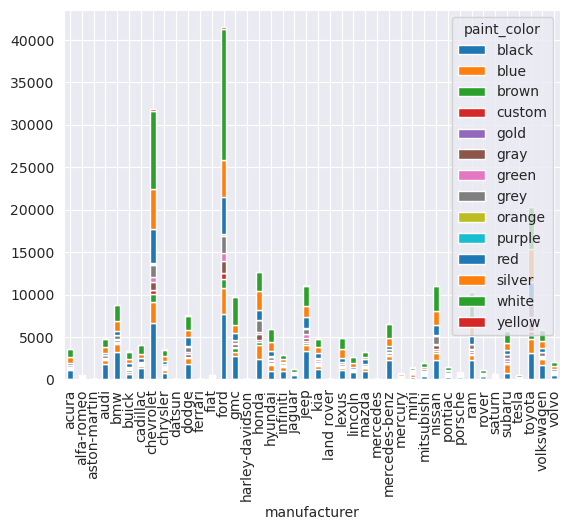

In [76]:
pd.crosstab(processed_train['manufacturer'], processed_train['paint_color']).plot.bar(stacked=True)

# Our CarFeatureEngineer: Smart Feature Engineering for Car Listings

`CarFeatureEngineer` is a custom `scikit-learn` transformer that enriches car listing datasets with interpretable features for price prediction or classification tasks.

---

## How It Works

### `__init__()`
- Configurable thresholds:
  - `state_popularity_threshold`: % threshold to mark a state as popular
  - `color_popularity_threshold`: % threshold to mark a color as common

### `fit(X)`
Learns from training data:
- Most frequent `state`s
- Most frequent `paint_color`s
- Top 20 most frequent `model`s

These are stored and reused during transformation.

### `transform(X)`
Creates new features by combining and transforming existing columns.
Handles missing columns gracefully.

---

## ✨ Engineered Features

| **Category**      | **Features**                                                | **Source Columns**              |
|-------------------|-------------------------------------------------------------|----------------------------------|
| **Time-Based**     | `car_age`, `is_recent_model`, `posting_month`, seasons      | `year`, `posting_date`          |
| **Location-Based** | `is_popular_state`, `is_northeast`, `is_urban_area`, etc.   | `state`, `lat`, `long`          |
| **Vehicle-Based**  | `is_truck_or_suv`, `has_many_cylinders`, `fuel_efficiency` | `type`, `cylinders_numeric`     |
| **Color/Model**    | `is_common_color`, `is_rare_color`, `is_popular_model`     | `paint_color`, `model`          |
| **Other**          | `condition_score`, `is_automatic`, `is_clean_title`, `is_domestic` | `condition`, `transmission`, `title_status`, `manufacturer` |

---


In [77]:
from sklearn.base import BaseEstimator, TransformerMixin

class CarFeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, state_popularity_threshold=0.15, color_popularity_threshold=0.1):
        self.state_popularity_threshold = state_popularity_threshold
        self.color_popularity_threshold = color_popularity_threshold
        self.state_popularity_ = None
        self.common_colors_ = None
        self.popular_models = None
        
    def fit(self, X, y=None):
        # Calculate state popularity
        if 'state' in X.columns:
            state_counts = X['state'].value_counts(normalize=True)
            self.state_popularity_ = state_counts[state_counts > self.state_popularity_threshold].index.tolist()
        
        # Calculate color popularity
        if 'paint_color' in X.columns:
            color_counts = X['paint_color'].value_counts(normalize=True)
            self.common_colors_ = color_counts[color_counts > self.color_popularity_threshold].index.tolist()
            
        self.popular_models_ = X['model'].value_counts().head(20).index


    def transform(self, X):
        X = X.copy()


        current_year = pd.Timestamp.now().year
        X['car_age'] = current_year - X['year']
        X['is_recent_model'] = (X['car_age'] <= 3).astype(int)
        
        # 1. Car age
        current_year = pd.Timestamp.now().year
        X['car_age'] = current_year - X['year']

        # 2. Is car new
        X['is_car_new'] = (X['year'] >= 2018).astype(int)

        # 3. Posting month & quarter
        if 'posting_date' in X.columns:
            X['posting_date'] = pd.to_datetime(X['posting_date'], errors='coerce')
            X['posting_month'] = X['posting_date'].dt.month
            X['posting_quarter'] = X['posting_date'].dt.quarter
            
        # 4. State Popularity (using fit-learned states)
        if hasattr(self, 'state_popularity_') and 'state' in X.columns:
            X['is_popular_state'] = X['state'].isin(self.state_popularity_).astype(int)
            
        # 5. Vehicle Type Features
        if 'type' in X.columns:
            X['is_truck_or_suv'] = X['type'].isin(['truck', 'SUV']).astype(int)
            
        # 6. Engine Features
        if 'cylinders_numeric' in X.columns:
            X['has_many_cylinders'] = (X['cylinders_numeric'] >= 6).astype(int)
            
        # 7. Temporal Listing Patterns (safe)
        if 'posting_date' in X.columns:
            X['posting_date'] = pd.to_datetime(X['posting_date'], errors='coerce')
            X['posting_season'] = X['posting_date'].dt.quarter.map({
                1: 'winter', 2: 'spring', 3: 'summer', 4: 'fall'
            })
            # One-hot encode season
            seasons = pd.get_dummies(X['posting_season'], prefix='season')
            X = pd.concat([X, seasons], axis=1)
            
        # 7. Odometer Features
        if 'odometer' in X.columns:
            X['mileage_category'] = pd.cut(
                X['odometer'],
                bins=[1500, 30000, 60000, 100000, float('inf')],
                labels=['low', 'medium', 'high', 'very_high']
            )
            
        # 8. Color Popularity
        if hasattr(self, 'common_colors_') and 'paint_color' in X.columns:
            X['is_common_color'] = X['paint_color'].isin(self.common_colors_).astype(int)
            X['is_rare_color'] = (~X['paint_color'].isin(self.common_colors_)).astype(int)
            
        # 9. Geographic Features
        if all(col in X.columns for col in ['lat', 'long']):
            # US regions (approximate)
            X['is_northeast'] = ((X['lat'] >= 40) & (X['long'] >= -80)).astype(int)
            X['is_west_coast'] = ((X['lat'] <= 42) & (X['long'] <= -114)).astype(int)
            X['is_south'] = ((X['lat'] <= 35) & (X['long'] >= -100)).astype(int)
            
            # Population density proxy
            X['is_urban_area'] = ((X['lat'].between(30, 47)) & 
                                 (X['long'].between(-85, -118))).astype(int)
            
        # 9. Condition Features
        if 'condition' in X.columns:
            condition_rank = {
            'salvage': 0,
            'fair': 1,
            'good': 2,
            'commercial': 3,
            'excellent': 4,
            'like new': 5,
            'new': 6
        }
            X['condition_score'] = X['condition'].map(condition_rank).fillna(2)
        
        # 10. Transmission Features
        if 'transmission' in X.columns:
            X['is_automatic'] = X['transmission'].str.contains('auto', case=False).astype(int)
            
        # 11. Title Status Features
        if 'title_status' in X.columns:
            X['is_clean_title'] = X['title_status'].str.contains('clean', case=False).astype(int)
            
        # 12. Manufacturer Features   
        if 'manufacturer' in X.columns:
            domestic_brands = ['ford', 'chevrolet', 'dodge', 'jeep', 'tesla', 'gmc']
            X['is_domestic'] = X['manufacturer'].str.lower().isin(domestic_brands).astype(int)
                
        # 13. Popular models
        X['is_popular_model'] = X['model'].isin(self.popular_models_).astype(int)
        
        # 14. fuel efficiency
        if all(col in X.columns for col in ['cylinders_numeric', 'type']):
            X['fuel_efficiency'] = np.where(
            X['type'].isin(['sedan', 'hatchback']),
            30 - (X['cylinders_numeric'] * 2),  # Estimate MPG
            20 - (X['cylinders_numeric'] * 1.5)  # Trucks/SUVs
        )

        return X

In [90]:
# Initialize with threshold 
fe = CarFeatureEngineer(
    state_popularity_threshold=0.15,  # States with >15% of listings
    color_popularity_threshold=0.5    # Colors with >10% occurrence
)

fe.fit(processed_train)

X_train_fe  = fe.transform(processed_train)

X_train_fe.columns

Index(['is_electric', 'is_recent_model', 'is_car_new', 'is_popular_state',
       'is_truck_or_suv', 'mileage_category', 'is_common_color',
       'is_rare_color', 'is_northeast', 'is_west_coast', 'is_south',
       'is_urban_area', 'condition_score', 'is_automatic', 'is_clean_title',
       'is_domestic', 'is_popular_model'],
      dtype='object')


Index(['price', 'year', 'manufacturer', 'model', 'condition', 'fuel',
       'odometer', 'title_status', 'transmission', 'drive', 'size', 'type',
       'paint_color', 'state', 'lat', 'long', 'log_price',
       'cylinders_confidence', 'cylinders_numeric', 'odometer_outlier',
       'odometer_imputed', 'log_odometer', 'is_electric', 'car_age',
       'is_recent_model', 'is_car_new', 'is_popular_state', 'is_truck_or_suv',
       'has_many_cylinders', 'mileage_category', 'is_common_color',
       'is_rare_color', 'is_northeast', 'is_west_coast', 'is_south',
       'is_urban_area', 'condition_score', 'is_automatic', 'is_clean_title',
       'is_domestic', 'is_popular_model', 'fuel_efficiency'],
      dtype='object')

### Post-Processing and Feature Engineering Analysis

This section of the code is dedicated to a comprehensive analysis of the dataset *after* initial preprocessing and the application of custom feature engineering (likely via the `CarFeatureEngineer` class described previously). The goal is to understand the characteristics of the newly formed features and assess the overall data quality before model training.

#### 1. Skewness Assessment of Numerical Features

* **Code:**
    ```python
    new_num_columns = ['year', 'car_age', 'log_odometer', 'cylinders_numeric']
    skewness = X_train_fe[new_num_columns].skew().sort_values(ascending=False)
    print("Skewness:\n", skewness)
    ```
* **Explanation:** Skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean.
    * This code snippet selects a specific set of numerical columns (`year`, `car_age`, `log_odometer`, `cylinders_numeric`) that are either original numerical features or new features engineered from them (e.g., `car_age` from `year`, `log_odometer` from `odometer`).
    * It then calculates the skewness for each of these columns.
    * **Purpose:** Understanding skewness is important for several reasons:
        * **Model Assumptions:** Many machine learning models (e.g., linear regression) assume that numerical features are normally distributed (i.e., have zero skewness).
        * **Outlier Impact:** Highly skewed data can be heavily influenced by outliers, which might disproportionately affect model performance.
        * **Transformations:** High skewness often indicates a need for data transformations (like log transformation, square root, etc.) to make the distribution more symmetrical and closer to normal, which can improve model performance.

#### 2. Outlier Detection using Interquartile Range (IQR)

* **Code:**
    ```python
    for col in new_num_columns:
        outliers = detect_outliers_iqr(X_train_fe, col) # Assumes detect_outliers_iqr is defined elsewhere
        print(f"{col}: {outliers.sum()} outliers")
    ```
* **Explanation:** The Interquartile Range (IQR) method is a robust way to identify outliers, less sensitive to extreme values than methods based on mean and standard deviation.
    * This loop iterates through the same `new_num_columns`.
    * It calls a pre-defined function `detect_outliers_iqr` (which is expected to be available in the environment) to count the number of outliers for each column.
    * **Purpose:** Identifying outliers is critical because:
        * **Data Quality:** Outliers can indicate data entry errors or unusual, but valid, observations.
        * **Model Robustness:** Outliers can significantly influence statistical measures (mean, standard deviation) and skew model training, leading to less robust or less accurate predictions. Understanding their presence guides decisions on handling them (e.g., removal, transformation, capping, or specific models robust to outliers).

#### 3. Outlier Detection using Z-score

* **Code:**
    ```python
    from scipy.stats import zscore
    z_scores = processed_train[num_cols].apply(zscore) # Assumes num_cols and processed_train are defined
    outliers_z = (z_scores.abs() > 3).sum()
    print("Outliers by Z-score:\n", outliers_z)
    ```
* **Explanation:** Z-score measures how many standard deviations an individual data point is from the mean of its dataset.
    * This section applies the Z-score calculation to a broader set of numerical columns (`num_cols`) within the `processed_train` DataFrame.
    * It then counts data points where the absolute Z-score is greater than 3. A common convention is to consider data points with a Z-score greater than +3 or less than -3 as outliers, as they are very far from the mean.
    * **Purpose:** Z-score based outlier detection is effective for data that is approximately normally distributed. It provides another perspective on outlier presence compared to the IQR method.

#### 4. Distribution Visualization (Histograms and Box Plots)

* **Code:**
    ```python
    new_cat_columns = ['year', 'log_odometer', 'lat', 'long', 'cylinders_numeric'] # Note: these are numerical
    for col in new_cat_columns:
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        sns.histplot(processed_train[col], kde=True, bins=50)
        plt.title(f'Distribution of {col}')
        plt.subplot(1, 2, 2)
        sns.boxplot(x=processed_train[col])
        plt.title(f'Boxplot of {col}')
        plt.tight_layout()
        plt.show()
    ```
* **Explanation:** Visualizing data distributions is crucial for gaining insights into the shape, spread, and potential issues within numerical features.
    * Despite the variable name `new_cat_columns`, the columns listed (`year`, `log_odometer`, `lat`, `long`, `cylinders_numeric`) are numerical, making histograms and box plots appropriate.
    * For each selected column:
        * **Histogram with KDE:** `sns.histplot(kde=True, bins=50)` displays the frequency distribution of the data, along with a Kernel Density Estimate (KDE) curve that approximates the probability density function. This helps in understanding the shape of the distribution (e.g., normal, skewed, multimodal).
        * **Box Plot:** `sns.boxplot` provides a visual summary of the five-number summary (minimum, first quartile (Q1), median, third quartile (Q3), and maximum), as well as clearly showing potential outliers as individual points.
    * **Purpose:** These plots help to:
        * **Confirm Skewness:** Visually confirm the skewness observed numerically.
        * **Identify Outliers:** Clearly show the presence and magnitude of outliers.
        * **Understand Spread:** Reveal the spread and central tendency of the data.
        * **Assess Transformations:** Help determine if data transformations (e.g., `log_odometer` already suggests one) have been effective in normalizing distributions.

#### 5. Numerical Report

* **Code:**
    ```python
    numerical_report(X_train_fe, new_num_columns) # Assumes numerical_report is defined
    ```
* **Explanation:** This line calls a custom function `numerical_report` (expected to be defined elsewhere in the codebase).
    * **Purpose:** Such a function typically generates a detailed summary table for numerical columns, including metrics like:
        * Count of non-null values
        * Number of missing values and their percentage
        * Mean, Median, Mode
        * Standard Deviation
        * Min, Max, Quartiles (25th, 50th, 75th percentiles)
        * Potentially, skewness and kurtosis
    This provides a quick, comprehensive overview of the statistical properties of the numerical features.

#### 6. `is_electric` Distribution Plot

* **Code:**
    ```python
    plt.figure(figsize=(8, 5))
    sns.countplot(x='is_electric', data=X_train_fe)
    plt.title('Distribution of Electric vs Non-Electric Cars')
    plt.xlabel('Car Type')
    plt.ylabel('Count')
    plt.xticks([0, 1], ['Non-Electric', 'Electric'])
    total = len(X_train_fe)
    for p in plt.gca().patches:
        percentage = f'{100 * p.get_height()/total:.1f}%'
        plt.gca().annotate(percentage,
                          (p.get_x() + p.get_width()/2., p.get_height()),
                          ha='center', va='center',
                          xytext=(0, 10),
                          textcoords='offset points')
    plt.show()
    ```
* **Explanation:** This section focuses on a specific binary categorical feature, `is_electric`.
    * `sns.countplot` is used to visualize the counts of each category within the `is_electric` column (presumably 0 for non-electric and 1 for electric).
    * The `plt.xticks` call explicitly labels the categories for clarity.
    * Crucially, the code calculates and displays the percentage of each category directly on the bars, providing immediate insight into the class distribution.
    * **Purpose:** This plot is essential for:
        * **Class Imbalance:** Identifying if there's a significant imbalance between electric and non-electric cars in the dataset, which can impact model training and require special handling (e.g., oversampling, undersampling, using appropriate evaluation metrics).
        * **Feature Understanding:** Providing a clear visual summary of a key feature's composition.

#### 7. Correlation Analysis with Target Variable

* **Code:**
    ```python
    correlation_analysis(X_train_fe, target='log_price', method='spearman', show_target_only=True) # Assumes correlation_analysis is defined
    ```
* **Explanation:** This line calls a custom function `correlation_analysis` to investigate the relationships between features and the target variable.
    * `X_train_fe`: The DataFrame containing the features.
    * `target='log_price'`: Specifies that the correlation should be calculated with `log_price` as the target variable. The `log_price` suggests that the original price target might have been log-transformed due to skewness, which is a common practice in regression tasks.
    * `method='spearman'`: Uses Spearman's rank correlation coefficient. Unlike Pearson correlation (which measures linear relationships), Spearman correlation assesses the monotonic relationship between two variables (i.e., whether they tend to move in the same direction, regardless of linearity). This is more robust to outliers and non-normal distributions.
    * `show_target_only=True`: This parameter suggests that the function will only display the correlations of all features with the `log_price` target, rather than a full pairwise correlation matrix of all features.
    * **Purpose:** Correlation analysis is fundamental for:
        * **Feature Selection:** Identifying features that have a strong relationship with the target variable, which are likely to be important for the model.
        * **Multicollinearity:** While this specific call focuses on the target, correlation analysis broadly helps in detecting multicollinearity (high correlation between independent features), which can cause issues in some models.
        * **Feature Understanding:** Gaining insights into how each feature influences the target variable (positively or negatively).
````

In [95]:
new_num_columns = ['year', 'car_age', 'log_odometer', 'cylinders_numeric']

# Check skewness
skewness = X_train_fe[new_num_columns].skew().sort_values(ascending=False)
print("Skewness:\n", skewness)

Skewness:
 car_age              3.427781
cylinders_numeric   -0.687004
year                -3.427781
log_odometer        -3.575084
dtype: float64


In [96]:
for col in new_num_columns:
    outliers = detect_outliers_iqr(X_train_fe, col)
    print(f"{col}: {outliers.sum()} outliers")

year: 8552 outliers
car_age: 8552 outliers
log_odometer: 11027 outliers
cylinders_numeric: 0 outliers


In [85]:
from scipy.stats import zscore

z_scores = processed_train[num_cols].apply(zscore)
outliers_z = (z_scores.abs() > 3).sum()
print("Outliers by Z-score:\n", outliers_z)

Outliers by Z-score:
 year                 4837
log_odometer         4816
lat                  2631
long                 3587
cylinders_numeric     173
dtype: int64


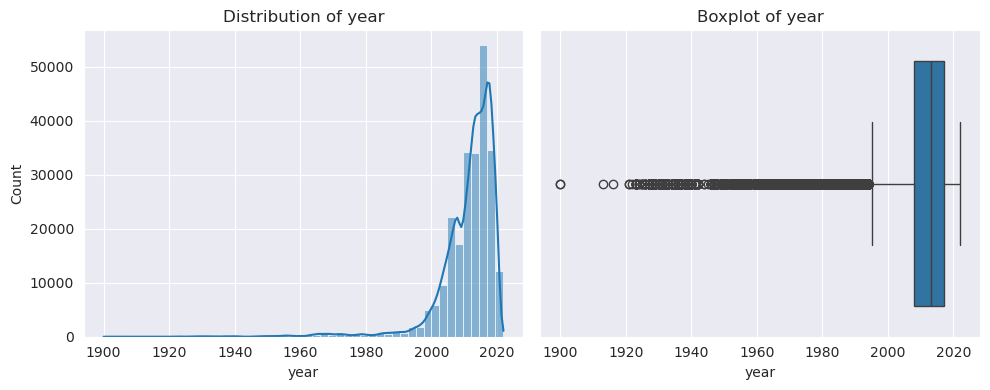

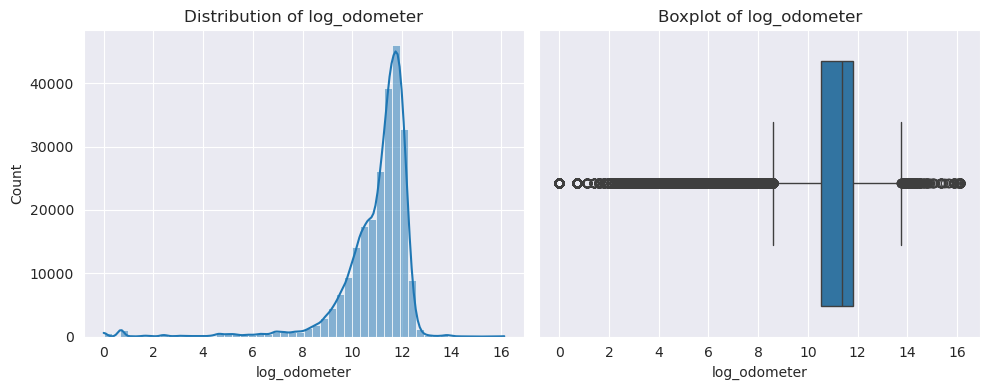

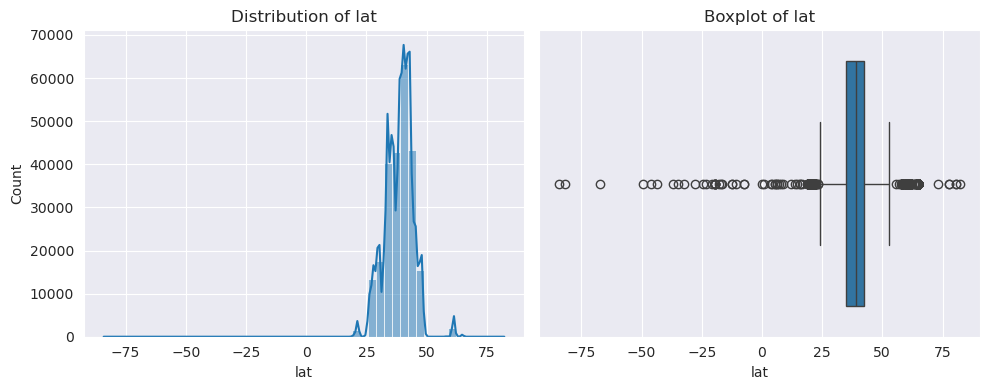

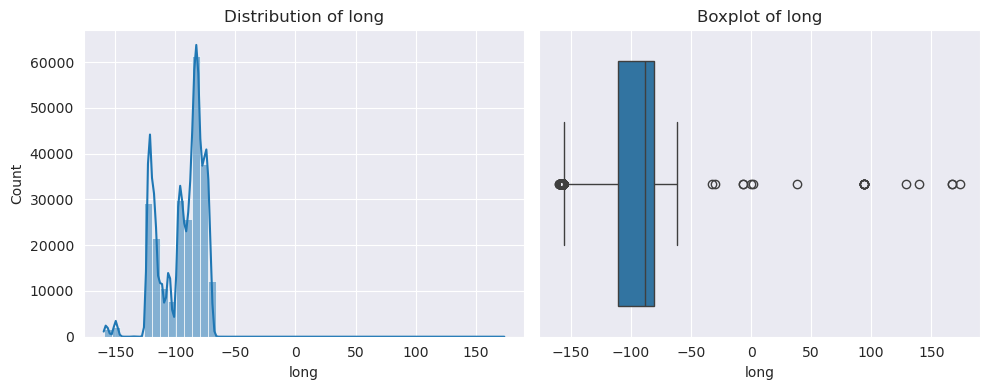

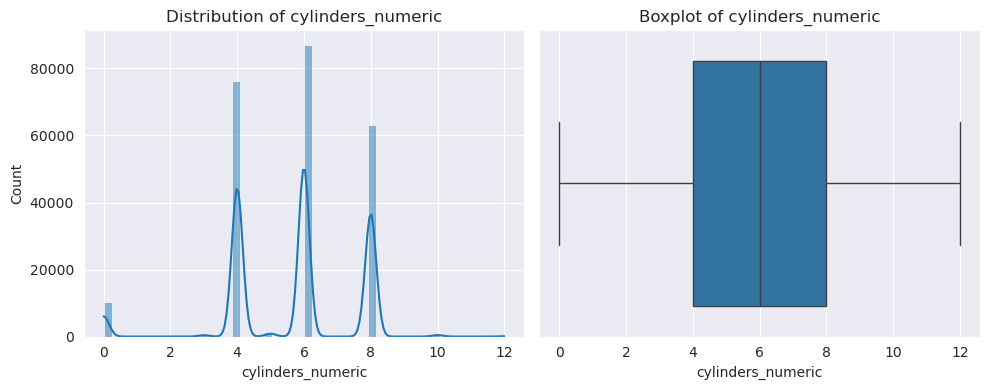

In [86]:
new_cat_columns = ['year', 'log_odometer', 'lat', 'long', 'cylinders_numeric']

for col in new_cat_columns:
    plt.figure(figsize=(10, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(processed_train[col], kde=True, bins=50)
    plt.title(f'Distribution of {col}')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=processed_train[col])
    plt.title(f'Boxplot of {col}')

    plt.tight_layout()
    plt.show()


🧮 year:
Skewness: -3.427759587960124
Kurtosis: 18.47797602310187


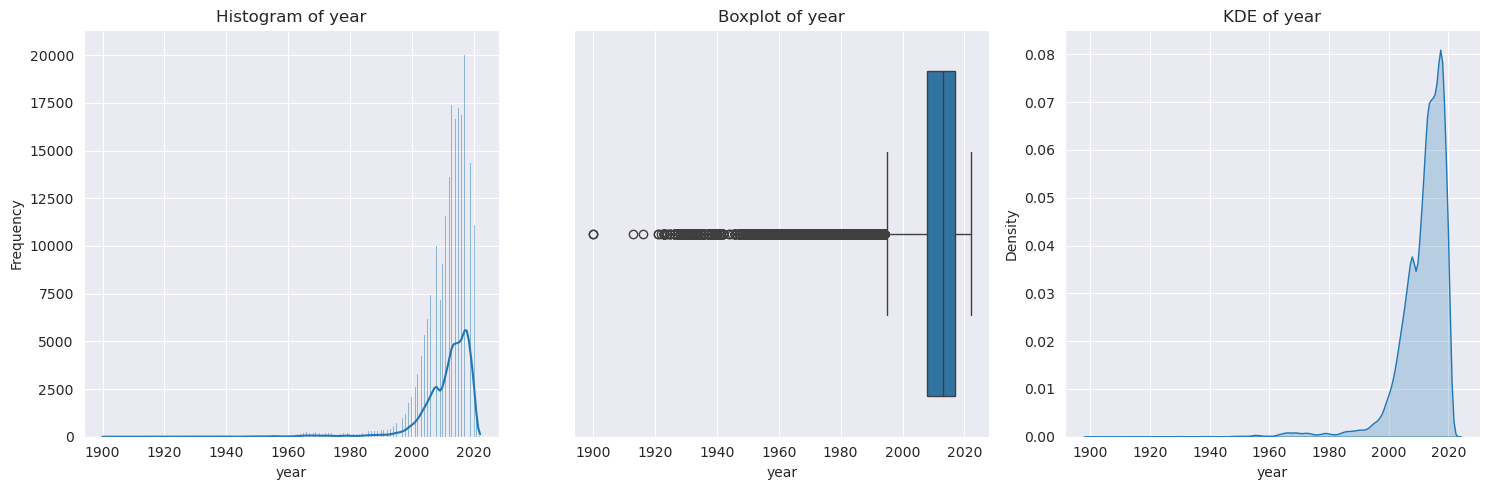


🧮 car_age:
Skewness: 3.427759587960138
Kurtosis: 18.477976023101938


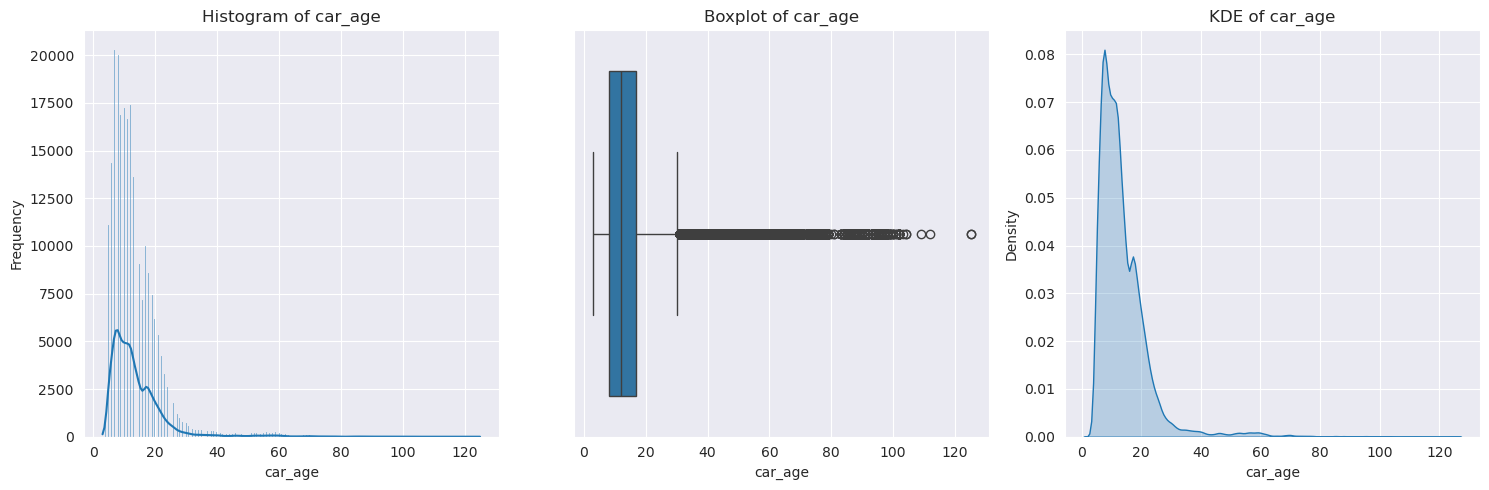


🧮 log_odometer:
Skewness: -3.5750619353268447
Kurtosis: 18.754451243551756


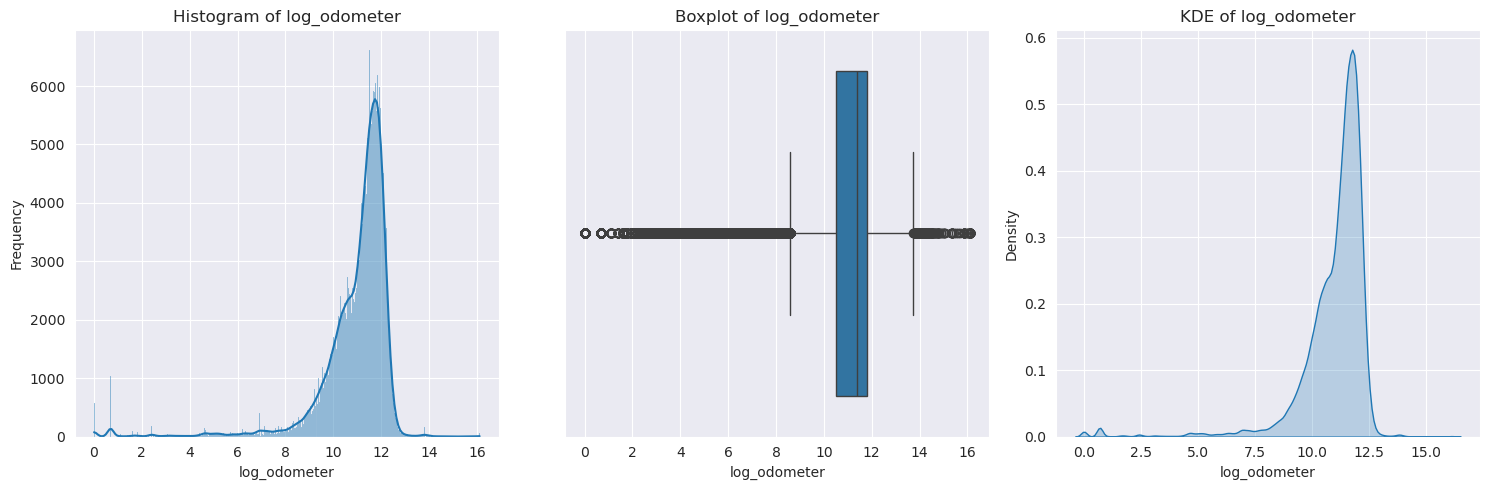


🧮 cylinders_numeric:
Skewness: -0.6869996395811852
Kurtosis: 0.8020833707697248


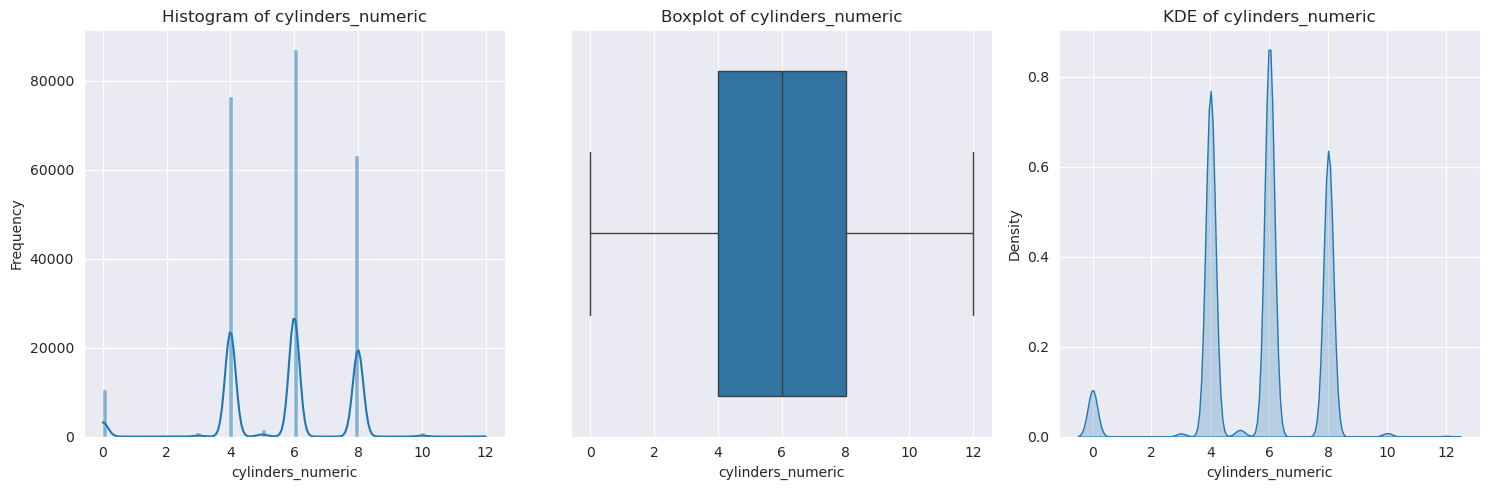

In [100]:
numerical_report(X_train_fe, new_num_columns)

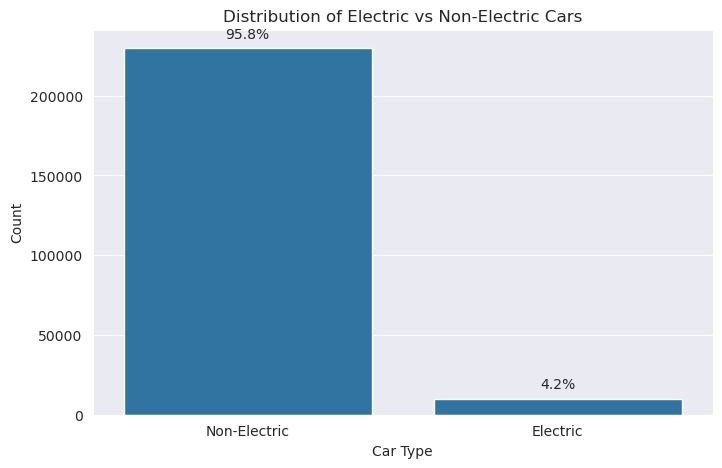

In [101]:
# Create the plot
plt.figure(figsize=(8, 5))
sns.countplot(x='is_electric', data=X_train_fe)

# Customize labels
plt.title('Distribution of Electric vs Non-Electric Cars')
plt.xlabel('Car Type')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Electric', 'Electric'])

# Add percentage annotations
total = len(X_train_fe)
for p in plt.gca().patches:
    percentage = f'{100 * p.get_height()/total:.1f}%'
    plt.gca().annotate(percentage, 
                      (p.get_x() + p.get_width()/2., p.get_height()), 
                      ha='center', va='center', 
                      xytext=(0, 10), 
                      textcoords='offset points')

plt.show()

🔗 Correlation between data and target value: log_price (spearman)
                      log_price
price                  1.000000
year                   0.653603
is_car_new             0.454529
cylinders_confidence   0.231734
cylinders_numeric      0.208411
has_many_cylinders     0.195840
is_clean_title         0.092248
is_domestic            0.090307
is_south               0.071250
is_truck_or_suv        0.030602
is_electric            0.018442
odometer_outlier      -0.001616
is_recent_model       -0.006702
is_west_coast         -0.026436
is_popular_model      -0.030474
lat                   -0.039375
is_northeast          -0.049738
long                  -0.060007
fuel_efficiency       -0.257052
is_automatic          -0.264080
log_odometer          -0.582045
odometer              -0.582045
car_age               -0.653603
odometer_imputed            NaN
is_popular_state            NaN
is_common_color             NaN
is_rare_color               NaN
is_urban_area               NaN


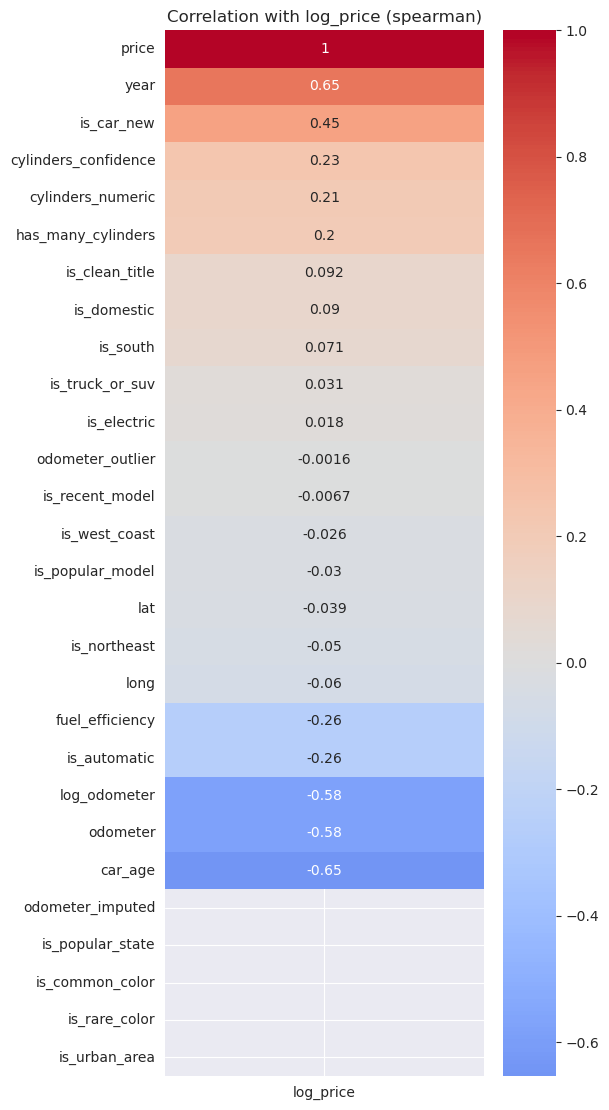

In [103]:
correlation_analysis(X_train_fe, target='log_price', method='spearman', show_target_only=True)

### Baseline Model: Random Forest Regressor

This section of the code establishes and evaluates a baseline machine learning model using a Random Forest Regressor for car price prediction. It encompasses the entire modeling workflow from data loading to final performance assessment.

#### 1. Data Loading and Initial Null Value Check

The process begins by loading preprocessed and feature-engineered training, validation, and test datasets from pickle files. Following the load, a custom function is utilized to display the null values and their percentages across all three datasets, ensuring data integrity post-preprocessing.

#### 2. Data Splitting and Target Transformation

The `price` column, which serves as the prediction target, is separated from the features in both the training and validation sets. To address potential skewness in price data and improve model performance, the `price` column is then log-transformed using `np.log1p()`.

#### 3. Defining Feature Groups

Features are explicitly categorized into groups based on their characteristics:
* **High Cardinality Categorical Features:** Such as `manufacturer`.
* **Low Cardinality Categorical Features:** Including `fuel`, `title_status`, `transmission`, `drive`, and `size`.
* **Numerical Features:** Like `year`, `cylinders_numeric`, `log_odometer`, `car_age`, and `fuel_efficiency`.
* **Binary Features:** A set of engineered binary indicators, e.g., `is_electric`, `is_car_new`, `is_popular_state`, etc.

This categorization is crucial for applying specific preprocessing steps to each type.

#### 4. Setting Up Preprocessing Pipelines

Scikit-learn pipelines are configured for each feature type:
* Numerical features are standardized using `StandardScaler()`.
* Low cardinality categorical features are transformed using `OneHotEncoder()` to create binary columns.
* High cardinality categorical features are processed with `TargetEncoder()` to convert categories into numerical values based on the target mean.
These individual pipelines are then combined into a `ColumnTransformer` to apply the correct preprocessing to each group of columns, while ensuring any unlisted columns are passed through without modification.

#### 5. Constructing the Full Model Pipeline

A comprehensive Scikit-learn `Pipeline` is created. This pipeline first applies all the defined preprocessing steps via the `ColumnTransformer`, and then feeds the processed data directly into a `RandomForestRegressor` for training. The Random Forest is configured for reproducibility and efficient parallel processing.

#### 6. Feature Set Validation Before Training

A step is included to identify and remove any columns from the training DataFrame that are not explicitly part of the defined feature groups. This ensures that only relevant features are passed to the model pipeline, preventing potential errors.

#### 7. Model Training and Performance Tracking

The complete pipeline is trained on the prepared training features and the log-transformed target prices. The duration of the training process is measured and reported.

#### 8. Validation Set Prediction and Evaluation

After training, the model makes predictions on the validation dataset. These log-transformed predictions are then inverse-transformed back to the original price scale. The model's performance on the validation set is assessed using Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and other metrics provided by a custom `evaluate` function.

#### 9. Final Test Set Evaluation and Visualization

Finally, the model's performance is evaluated on the entirely unseen test dataset. Predictions are made and inverse-transformed to the original price scale, followed by a full evaluation using the `evaluate` function. A custom `plot_results` function is then called to visually represent the model's performance on the test set.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
import re
tqdm.pandas()
from collections import defaultdict
import os
os.chdir('C:/Users/wissam_T/Desktop/5th/2nd semester/ml + dm')

In [6]:
ready_train = pd.read_pickle('data/train_fe.pkl')
ready_val = pd.read_pickle('data/val_fe.pkl')
ready_test = pd.read_pickle('data/test_fe.pkl')

In [9]:
null_with_percentage(ready_train)
null_with_percentage(ready_val)
null_with_percentage(ready_test)

Null Value Counts and Percentages per Column:
                      Null Count  Null Percentage
price                          0              0.0
is_electric                    0              0.0
is_recent_model                0              0.0
is_car_new                     0              0.0
is_popular_state               0              0.0
is_truck_or_suv                0              0.0
has_many_cylinders             0              0.0
mileage_category               0              0.0
is_common_color                0              0.0
is_rare_color                  0              0.0
is_northeast                   0              0.0
is_west_coast                  0              0.0
is_south                       0              0.0
is_urban_area                  0              0.0
condition_score                0              0.0
is_automatic                   0              0.0
is_clean_title                 0              0.0
is_domestic                    0              0.0
is_p

In [11]:
# === Split data ===
y_train = ready_train['price']
y_val = ready_val['price']
train = ready_train.drop('price', axis=1)
val = ready_val.drop('price', axis=1)

y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

# Baseline model RandomForestRegressor

In [13]:
import time
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold


# === Define column groups ===
high_cardinality_cats = ['manufacturer']
low_cardinality_cats = ['fuel', 'title_status', 'transmission', 'drive', 'size']
numerical_cols = ['year', 'cylinders_numeric', 'log_odometer', 'car_age', 'fuel_efficiency']
binary_cols = [
    'is_electric', 'is_car_new', 'is_popular_state',
    'is_truck_or_suv', 'has_many_cylinders', 'is_common_color', 'is_rare_color',
    'is_northeast', 'is_west_coast', 'is_south', 'is_urban_area', 'is_automatic',
    'is_clean_title', 'is_domestic', 'is_popular_model'
]



# === Pipelines ===
num_pipe = Pipeline([
    ('scaler', StandardScaler())
])

low_cat_pipe = Pipeline([
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

high_cat_pipe = Pipeline([
    ('target_enc', TargetEncoder())
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, numerical_cols),
    ('low_cat', low_cat_pipe, low_cardinality_cats),
    ('high_cat', high_cat_pipe, high_cardinality_cats)
], remainder='passthrough')

# === Model Pipeline ===
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor (
        random_state=42,
        verbose=1,
        n_jobs=-1
    ))
])

print("Remaining columns after transformation:")
cols_to_drop = (set(train.columns) - set(numerical_cols) - set(low_cardinality_cats) - set(high_cardinality_cats) - set(binary_cols))

train_copy = train.copy()
print(cols_to_drop)
train_copy.drop(columns=cols_to_drop, inplace=True)
print(train_copy.columns)

Remaining columns after transformation:
{'paint_color', 'type', 'condition', 'odometer_imputed', 'mileage_category', 'model', 'long', 'cylinders_confidence', 'odometer', 'lat', 'condition_score', 'state', 'is_recent_model', 'odometer_outlier'}
Index(['year', 'manufacturer', 'fuel', 'title_status', 'transmission', 'drive',
       'size', 'cylinders_numeric', 'log_odometer', 'is_electric', 'car_age',
       'is_car_new', 'is_popular_state', 'is_truck_or_suv',
       'has_many_cylinders', 'is_common_color', 'is_rare_color',
       'is_northeast', 'is_west_coast', 'is_south', 'is_urban_area',
       'is_automatic', 'is_clean_title', 'is_domestic', 'is_popular_model',
       'fuel_efficiency'],
      dtype='object')


In [15]:
# === Fit & Track Time ===
print("Training started...")
start = time.time()
pipeline.fit(train_copy, y_train_log)
end = time.time()
print(f"✅ Training completed in {(end - start):.2f} seconds.")

# === Predict & Evaluate ===
y_pred_log = pipeline.predict(val)
y_pred = np.expm1(y_pred_log)  # predicted prices in original scale

mse = mean_squared_error(y_val , y_pred)
rmse = np.sqrt(mse) # Take the square root to get RMSE
metrics = evaluate(y_val, y_pred)

Training started...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


✅ Training completed in 26.61 seconds.


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


RMSE: 16495.3382
R²: 0.2362
MAE: 6274.2861
MedAE: 2264.9925


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.6s finished


In [24]:
X_test = ready_test.drop(columns=['price'])  # Features (drop the target column)
y_test = ready_test['price']  # Target column

y_pred_log = pipeline.predict(X_test)
y_pred = np.expm1(y_pred_log)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.4s finished


In [17]:
import seaborn as sns

RMSE: 17150770.8811
R²: -0.0000
MAE: 94180.6616
MedAE: 2319.5318


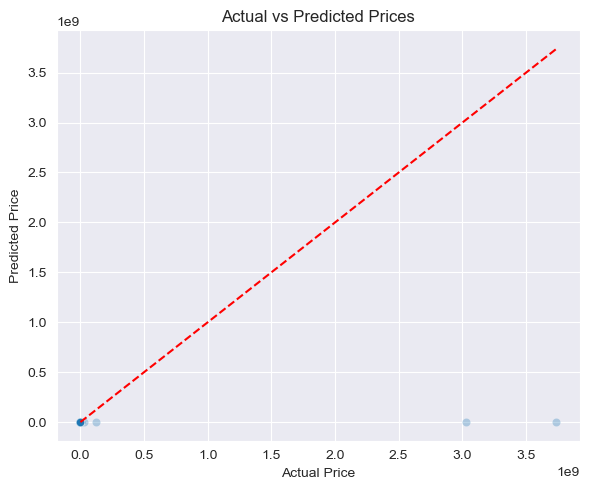

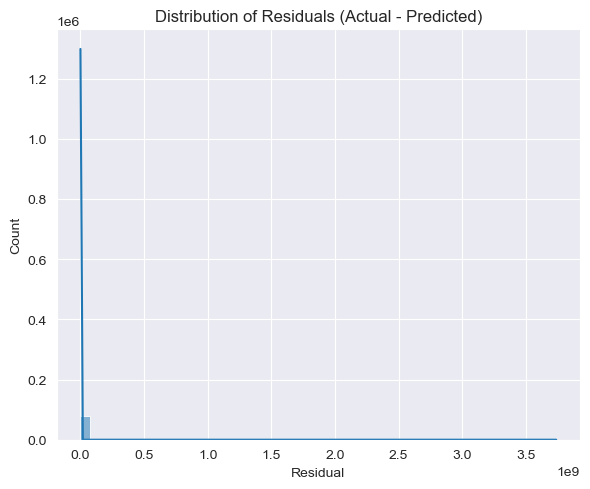

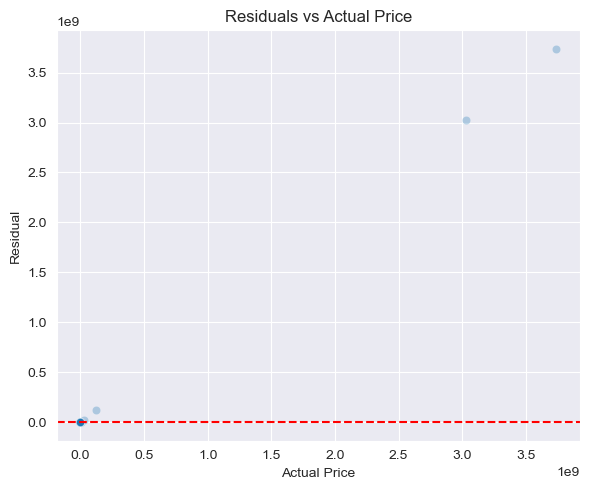

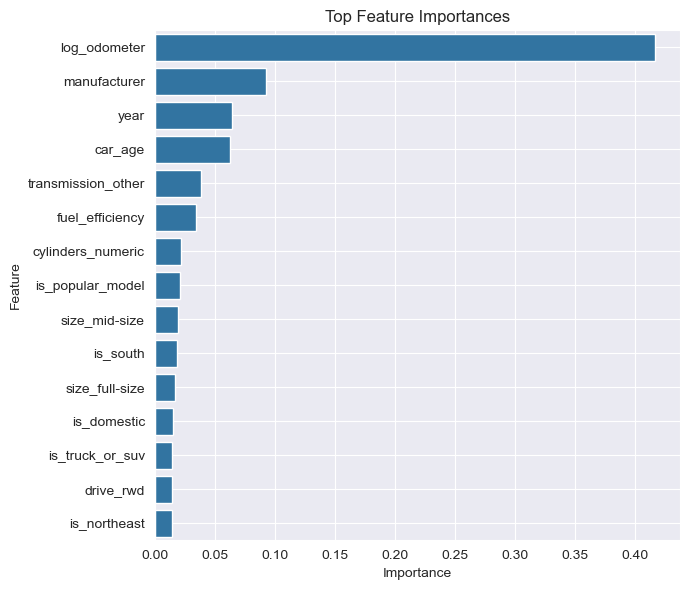

In [26]:
evaluate(y_test, y_pred)
plot_results(pipeline, ready_test, y_test, y_pred_log)

# HistGradientBoostingRegressor

In [82]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

numeric_features = X_sample.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_sample.select_dtypes(include=['object', 'category']).columns.tolist()

y_sample_log = np.log1p(y_sample)

X_temp, X_test, y_temp, y_test_log = train_test_split(X_sample, y_sample_log, test_size=0.2, random_state=42)
X_train, X_val, y_train_log, y_val_log = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', HistGradientBoostingRegressor(random_state=42, verbose=1))
])

param_grid = {
    'model__max_iter': [100],
    'model__learning_rate': [0.05],
    'model__max_depth': [10],
    'model__validation_fraction': [0.1],
    'model__n_iter_no_change': [5]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train_log)

val_preds_log = grid_search.predict(X_val)
val_preds = np.expm1(val_preds_log)
y_val = np.expm1(y_val_log)

val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
print("✅ أفضل المعاملات:", grid_search.best_params_)
print(f"✅ RMSE على مجموعة التحقق: {val_rmse:,.2f}")

best_model = grid_search.best_estimator_
test_preds_log = best_model.predict(X_test)
test_preds = np.expm1(test_preds_log)
y_test = np.expm1(y_test_log)

test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
test_r2 = r2_score(y_test, test_preds)

print(f"📊 RMSE على مجموعة الاختبار: {test_rmse:,.2f}")
print(f"📈 R² Score على مجموعة الاختبار: {test_r2:.4f}")


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Binning 0.063 GB of training data: 1.517 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 10, in 0.279s
[2/100] 1 tree, 31 leaves, max depth = 10, in 0.261s
[3/100] 1 tree, 31 leaves, max depth = 10, in 0.287s
[4/100] 1 tree, 31 leaves, max depth = 10, in 0.282s
[5/100] 1 tree, 31 leaves, max depth = 10, in 0.273s
[6/100] 1 tree, 31 leaves, max depth = 9, in 0.285s
[7/100] 1 tree, 31 leaves, max depth = 10, in 0.278s
[8/100] 1 tree, 31 leaves, max depth = 10, in 0.277s
[9/100] 1 tree, 31 leaves, max depth = 9, in 0.276s
[10/100] 1 tree, 31 leaves, max depth = 10, in 0.260s
[11/100] 1 tree, 31 leaves, max depth = 10, in 0.286s
[12/100] 1 tree, 31 leaves, max depth = 10, in 0.289s
[13/100] 1 tree, 31 leaves, max depth = 10, in 0.261s
[14/100] 1 tree, 31 leaves, max depth = 10, in 0.254s
[15/100] 1 tree, 31 leaves, max depth = 10, in 0.303s
[16/100] 1 tree, 31 leaves, max depth = 10, in 0.268s
[17/100] 1 t